## Chapter 29     
# Bayesian Modeling and Markov Chain Monte Carlo


## Overview

In a previous lesson we explored the basics of Bayesian parameter estimation. The methods we used are restricted to only simple models. This lesson introduces you to a general and flexible form of Bayesian modeling using the **Markov chain Monte Carlo (MCMC)** methods. MCMC methods can be extended to extremely complex models, including **Bayesian hierarchical models**.  

![](img/Flips.png)


## Software

Most Bayes software packages use efficient Markov chain Monte Carlo (MCMC) methods. The most widely used of these is [Stan](https://mc-stan.org/), named for mathematician Stanislaw Ulam. Stan also includes variational approximation methods. 

A powerful, and generally more user friendly, Python package is [PyMC](https://docs.pymc.io/). The code in this notebook uses PyMC3. The documentation for PyMC3 includes an excellent [Getting Started Jupyter Notebook](https://docs.pymc.io/notebooks/getting_started.html) along with other tutorials. Additionally you can find a number of [example Jupyter notebooks](https://docs.pymc.io/nb_examples/index.html) for many application areas.  

First, you need to make sure your environment is ready to run the code in this notebook. The following notes will help you do so. You will need to restart your Jupyter server for any newly installed packages to be loaded.  

***
**Note 1::**  To execute the code in this notebook you will also need to install [ArviZ](https://arviz-devs.github.io/arviz/#) by following [these directions](https://arviz-devs.github.io/arviz/getting_started/Installation.html). Typically a Conda installation is preferred. 

***
**Note 2:** To execute the code in this notebook you must have installed PyMC3 by following [these instructions](https://www.pymc.io/projects/docs/en/stable/installation.html). When you import PyMC, you may see a warning message, which tells you ` g++ not available`, and which will affect the computational performance of PyMC. In this case you need to run the following at a command prompt: `conda install m2w64-toolchain`.   

***
**Note 3:** Since the installation of PyMC can be difficult, you may chose to run this notebook in Google [Colaboratory](https://colab.research.google.com/). Colab has PyMC installed. 
***  

## Review of Bayes Theorem

Recall Bayes theorem:

$$P(A|B) = \frac{P(A)P(B|A)}{P(B)}$$

Computing the normalization $P(B)$ is a bit of a mess. But fortunately, we don't always need the denominator. We can rewrite Bayes Theorem as:

$$𝑃(𝐴│𝐵)=𝑘∙𝑃(𝐵|𝐴)𝑃(𝐴)$$

Ignoring the normalizaton constant $k$, we get:

$$𝑃(𝐴│𝐵) \propto 𝑃(𝐵|𝐴)𝑃(𝐴)$$

### Bayesian parameter estimation

How to we interpret the relationships shown above? We do this as follows:

$$Posterior\ Distribution \propto Likelihood \bullet Prior\ Distribution \\
Or\\
𝑃(𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠│𝑑𝑎𝑡𝑎) \propto 𝑃(𝑑𝑎𝑡𝑎|𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠)𝑃(𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠) $$

These relationships apply to the observed data distributions, or to parameters in a model (partial slopes, intercept, error distributions, lasso constant,…). 

## Grid Sampling and Scalability

Real-world Bayes models have large numbers of parameters, even into the millions. As a naive approach to Bayesian analysis would be to simply grid sample across the dimensions of the parameter space. However, grid sampling will not scale. To underestand the scaling problem, do the following thought experiment, where each dimension is sampled 100 times:

- For a 1-parameter model: $100$ samples.
- For a 2-parameter model: $100^2 = 10000$ samples.
- For a 3-parameter model: $100^3 = 10^5$ samples.
- For a 100-parameter model: $100^{100} = 10^{102}$ samples. 

As you can see, the compuational complexity of grid sampling has **exponential scaling** with dimensionality. Clearly, we need a better approach. 

## Introduction to Markov Chain Monte Carlo

Large-scale Bayesian models use a family of efficient sampling methods known as **Markov chain Monte Carlo sampling**. Rather that systematically sampling on a grid MCMC methods sample distributions randomly. While MCMC methods are computationally efficient, but requires effort to understand how it works and what to do when things go wrong. 

In [1]:
import pymc
import arviz as az
import pandas as pd
import numpy as np
import numpy.random as nr
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style='ticks', palette='Set2')

### What is a Markov process?

As you might guess from the name, a MCMC sampling uses a chain of **Markov sampling processes**. A Markov process is a **stochastic process** that a makes transition from a current state, $X_t$, to some next state, $X_{t+1}$, with some probability $\Pi$. A Markov process has **no dependency on past states**. We can summarize properties of a Markov process:  
- $X_t$ is the **state vector** of **state probabilities** for $N$ possible states  
   $$X_t = [x_1, x_2, x_3, \ldots, x_N]$$
- The probability of transition from one state to another is parameterized by a matrix of probabilities, $\Pi$, of dim N X N for N possible state transitions,  
- $\Pi$  only depends on the current state, $X_t$,     
- The transition can be to current state.   

Since a Markov transition process depends only on the current state and not the history, we say a Markov process is **memoryless**. We can express the sequence of a Markov transition processes as:

$$p(X_{t + 1}| X_t, X_{t-1}, X_{t-2}, \ldots, X_0) = p(X_{t + 1}| X_t)$$

Notice that, since the Markov process is memoryless, the transition probability only depends on the current state, $x_t$. There is no dependency on any previous states, $X_{t-1}, X_{t-2}, \ldots, X_0$. 

For a system with $N$ possible states we can write the **transition probability matrix**, $\Pi$, from one state to another as follows:

\begin{align}
\Pi &= 
\begin{bmatrix}
\pi_{1,1} & \pi_{1,2} & \cdots & \pi_{1, N}\\
\pi_{2,1} & \pi_{2,2} & \cdots & \pi_{2,N}\\
\cdots & \cdots & \cdots & \cdots \\
\pi_{N,i} & \pi_{N,2} & \cdots & \pi_{N,N}
\end{bmatrix}\\
&where\\
\pi_{i,j} &= probability\ of\ transition\ state\ x_j\ to\ state\ x_i\\
&and\\
\pi_{i,i} &= probability\ of\ staying\ in\ state\ x_i\\
&further\\
\pi_{i,j} &\ne \pi_{j,i}\ in\ general
\end{align}

Notice that the probability of transition does not depend on the previous state history.

### Example of a Markov Process

To make the foregoing more concrete let's construct a simple example. We will start with a system of 3 states, $\{ x_1, x_2, x_3 \}$. The transition matrix is:    

$$\Pi = 
\begin{bmatrix}
\pi_{1,1} & \pi_{1,2} & \pi_{1,3}\\
\pi_{2,1} & \pi_{2,2} & \pi_{2,3}\\
\pi_{3,1} & \pi_{3,2} & \pi_{3,3}
\end{bmatrix}
= 
\begin{bmatrix}
0.5 & 0.0 & 0.6\\
0.2 & 0.3 & 0.4\\
0.3 & 0.7 & 0.0
\end{bmatrix}
$$

There are some key points to notice in this transition probability matrix.   
- The probabilities of transition from a state is given in each column. Necessarily, the probabilities in each column must add to 1.0.  
- The probabilities of a transition to the same state are given along the diagonal of the matrix.   
- Some transitions are not possible. These transitions have a probability of 0.0.    

Let's apply this probability matrix to a set of three possible states. As an example, let the **state vector** represent being in the first state at time step $t$; $\vec{X_t} = [1,0,0]$. After a state transition, we compute the probability of being in each of the three possible states at the next time step, $t+1$, as:  

$$\vec{X}_{t+1}  = \Pi\ \vec{X}_t = 
\begin{bmatrix}
0.5 & 0.0 & 0.6\\
0.2 & 0.3 & 0.4\\
0.3 & 0.7 & 0.0
\end{bmatrix} 
\begin{bmatrix}
1\\
0\\
0
\end{bmatrix} =
\begin{bmatrix}
0.5 \\
0.2 \\
0.3 
\end{bmatrix} 
$$

> **Exercise 29-1:**  Based on the transition probability matrix above, answer the following questions:   
> 1. Which state cannot transition to the same state? 
> 2. What is the minimum number of state transitions required to transition from the second state (second column) to the first state (first column)? 

> **Answers:**    
> 1. State 3 cannot transition to itself as its diagonal value is 0.0.
> 2. The minimum number of state transitions required is 2 (E.g. 2->3->1), as pi1,2 is 0.0, so it cannot directly transition to the  first state.    

### From Markov process to Markov chain    

So far, we have only discussed a single step Markov process. That is, the process for a single state transition. What happens when there is a series of transitions? A sequence of such transitions is known as a **Markov chain**. There are two major behaviors observed with Markov Chains:  
1. **Episodic Markov chains** have a **terminal state**. The terminal state can only transition to itself. Once the system is in the terminal state, we say that the episode has ended. Episodic processes are not of direct interest here, and we will not pursue them further.   
2. **Continuous Markov chains** have no terminal state and continue indefinitely, at least in principle. Continuous Markov chains sample probability distribution, and are ideal for estimating Bayesian posterior distributions.  

As already indicated, a Markov chain comprises a number of state transitions, one after another. Consider a chain of $n$ state transitions, $\{t_1, t_2, t_3, \ldots, t_n \}$. Each transition in this process has the probabilities given by the state transition matrix, $\Pi$.            

To estimate the probabilities of being in the states we use a special case known as a **stationary Markov chain**. We will not discuss the technical mathematical details here. Here we will just summarize the key result: Over a large number of time steps the number of times the states are visited is proportional to the state probabilities. Starting with some initial state, $\vec{X}_0$, we can write the relationship as a continuous Markov chain:   

$$\Pi\ \Pi\ \Pi\ \ldots \Pi\ \vec{X}_t = \Pi^n\ \vec{X}_t  \xrightarrow[\text{$n \rightarrow \infty$}]{} \vec{p(X)}$$    

Notice that in the above, we can find the probabilities of the states without ever actually knowing the values of the transition matrix, $\Pi$. As long as we can repeatedly sample the stochastic Markov process, we can estimate the state probabilities. This is the key concept of Markov Chain Monte Carlo sampling. 

As we proceed with this lesson we will use stationary Markov chains to estimate posterior probabilities of Bayesian models. The method relies on the result that the state probabilities converge eventually. As a consequence, we can develop flexible methods for sampling posterior distributions using Markov chain Monte Carlo. In summary, the model is sampled using a Markov chain and the sampled distribution should converge to the posterior distribution.    

> **Exercise 29-2:** After a large number of transitions, the probabilities of states reach a steady state. In the cell below create and execute code to compute the steady state probabilities using 1000 state transitions. Use the transition probability matrix shown above. Notice that starting state vales do not matter.       

In [2]:
# Define the transition matrix
transition_matrix = np.array([
    [0.5, 0.0, 0.6],
    [0.2, 0.3, 0.4],
    [0.3, 0.7, 0.0]
])

# Initialize a random state vector
state_vector = np.array([1.0, 0.0, 0.0])  
# Number of transitions
num_transitions = 1000

# Perform the transitions
for _ in range(num_transitions):
    state_vector = np.dot(transition_matrix, state_vector)

# The state_vector now should represent the steady state distribution
print("Steady state probabilities after 1000 transitions:")
print(state_vector)


Steady state probabilities after 1000 transitions:
[0.3853211  0.29357798 0.32110092]


## MCMC and the Metropolis-Hastings Algorithm

Using the principle of Markov chains, a number of MCMC algorithms have been developed over time to sample posterior distributions of Bayesian models. The first MCMC sampling algorithm developed is the **Metropolis-Hastings (M-H) algorithm** (Metropolis et al. (1953), Hastings (1970)). This algorithm is often referred to as simply the Metropolis algorithm or the M-H algorithm. 

The M-H algorithm has the following steps to estimate the posterior density of the parameters:
The M-H algorithm has the following steps to estimate the posterior density of the parameters:
1. Pick a starting point in the parameter space       
2. Choose a nearby point in parameter space randomly from a **sampling distribution**   
3. Evaluate the posterior at this point   
   - Product of the likelihood $P(data|parameters)$ and prior, $P(parameters)$     
4. Use the following **decision rule to accept or reject** the new sample: 
  - If the likelihood, $p(data | parameters)$, of the new point is greater than your current point, accept new point and move there.
  - If the likelihood of the new point is less than your current point, only accept with probability according to the ratio:  
$$Acceptance\ probability\ = \frac{p(data | new\ parameters)}{p(data | previous\ parameters)}$$.
5. If the sample is accepted, compute the posterior density at the new sample point    
6. Repeat steps, 2, 3, 4 and 5, many times, until convergence     


Eventually, this algorithms converges and the posterior distribution is estimated. The M-H random sampling algorithm is far more **sample efficient** than naive grid sampling. To build some intuition, consider that since the M-H algorithm probabilistically samples the parameter space we only need to visit a limited number of points, rather than sample an entire grid. 

Now that we have outlined the basic Metropolis-Hastings MCMC algorithm, let's examine some of its properties.
- The M-H algorithm is **guaranteed to eventually converge** to the underlying distribution. But as a practical issue, convergence can be quite slow. The convergence can be too slow to be useful for complex problems with high-dimensional parameter spaces.   
- If there is high **serial correlation** from one sample to the next in M-H chain converges slowly. In this case we say the Markov chain has low **sample efficiency**. 
- To ensure efficient convergence the algorithm must be ‘tuned’. The tuning involves finding a good dispersion parameter value for the state sampling distribution. This parameter determines the size of the jumps the algorithm makes in the parameter space. For example if we use Normal distribution we must pick the variance, $\sigma^2$. If $\sigma^2$ is too small, the chain will only search the space slowly, using small jumps. If $\sigma^2$ is too big, there are large jumps which also slows convergence, since the sampling of high density regions will be less likely. 

### M-H algorithm example

Let's make these concepts concrete, by trying a simple example. We will find a sample estimate of the probability density of a bivariate Normal distribution.     

As a first step, lets plot a set of points with density determined by the bivariate Normal distribution. Execute the code below and examine the resulting plot.

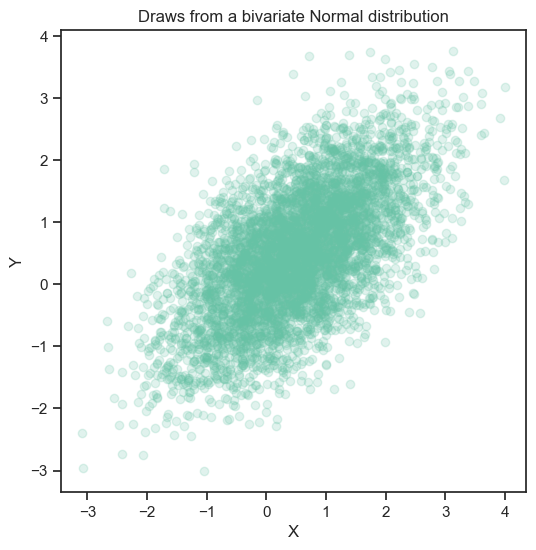

In [3]:
def plot_bi_variate(x, title='Draws from a bivariate Normal distribution'):
    ## Plot bi-variable points
    fig, ax = plt.subplots(figsize=(6,6)) 
    ax.scatter(x[:, 0], x[:, 1], alpha=.2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    _=ax.set_title(title)

np.random.seed(7799)
## Define the covariance and mean of the bivariate Normal. 
sigma = np.array([[1, .6], [.6, 1]])
mu = np.array([.5, .5])
## Sample 5000 realizations from the bivariate Normal
random_points = np.random.multivariate_normal(mean=mu, cov=sigma,  size=5000)

## Plot the result
plot_bi_variate(random_points)

This plot looks as expected. The density of the dots is proportional to the probability density. You can see the effect of the covariance structure in the elliptical shape of the cloud of points. 

As a next step, let's look at the density of the marginal distributions of the $X$ and $Y$ variables. The code in the cell below plots histogram and density plots of the marginals. Execute this code and examine the result. 

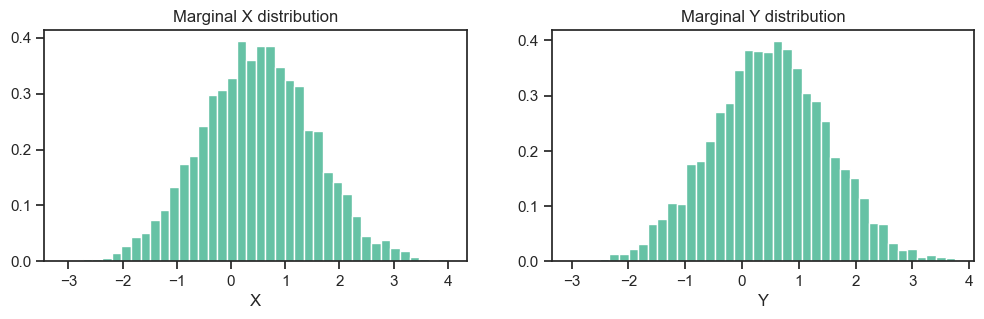

In [4]:
def plot_marginals(x):
    fig, ax = plt.subplots(1, 2, figsize=(12,3)) 
    ax[0].hist(x[:, 0], density=True, bins=40)
    ax[0].set_title('Marginal X distribution')
    ax[0].set_xlabel('X')
    ax[1].hist(x[:, 1], density=True, bins=40)
    ax[1].set_title('Marginal Y distribution')
    ax[1].set_xlabel('Y')  
    
plot_marginals(random_points)

> **Exercise 29-3:** Examine the plots above and answer the following questions.   
> 1. Do these marginal distributions appear approximately Normal? 
> 2. Do these marginal distributions exhibit any noticeable skewness or heavy tails? Is this behavior to be expected? 

> **Answers:**      
> 1. Yes, they look approx. normal.     
> 2. The marginal distributions show a very slight skewness. This is normal given the sample size and is not expected to be perfect.

Now, we are ready to sample these data using the M-H MCMC algorithm. The code in the cell below performs the following operations:

1. Compute the likelihood of the bi-variate Normal distribution. 
2. Initialize the chain.
3. Initialize some performance statistics.
4. Sample the likelihood of the data using the M-H algorithm.
5. Plot the result.

Execute this code and examine the result. 

(2000, 2)


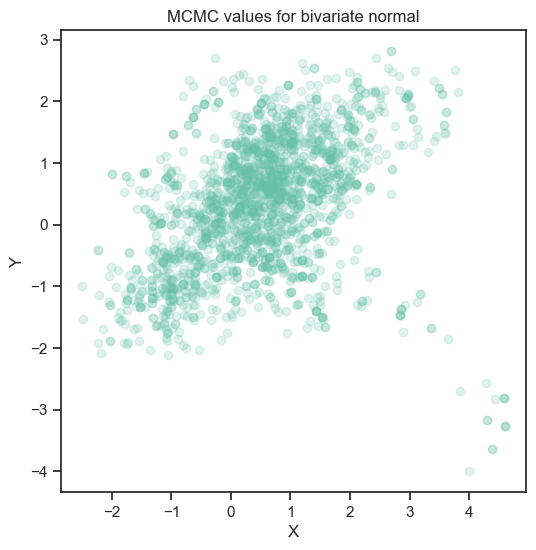

In [5]:
# Calculate the likelihood of a vector `x` for a multivariate normal
# distribution MVN(mu, sigma)
def likelihood(x, mu, sigma):
    return ss.multivariate_normal.pdf(x, mu, sigma)

# Initialize the output array
chain_length = 2000
chain = np.zeros((chain_length,2))
# where to start
chain[0,:] = [4.0,-4.0]


def M_H_sample(start, chain_length, x):
    ## Evaluate the current position
    current_likelihood = likelihood(start[0], mu, sigma)
    # Keep track of how often we accept or reject a proposal
    accept_count = 0
    reject_count = 0

    for i in range(chain_length-1): # chain length minus 1 because we already have a point (the starting point)
        # Sample the direction of the move we'll propose
        delta = nr.multivariate_normal([0, 0], np.diag([.1, .1]))
        # Our new proposal point is our previous position plus the sampled move
        proposed = chain[i,:] + delta
        proposed_likelihood = likelihood(proposed, mu, sigma)
        
        ## Accept according to probability 
        ## Two cases, are taken care of by one if statement since the uniform
        ## distribution is on the range [0-1], exceeding a random value is the 
        ## positive decision.  
        if (nr.uniform() < (proposed_likelihood / current_likelihood)):
            accept_count += 1
            current_likelihood = proposed_likelihood
            chain[i+1,:] = proposed
        else:
            chain[i+1,:] = chain[i,:]
            reject_count += 1 
    ## Return the result        
    return accept_count, reject_count, chain            

np.random.seed(1211)
## Sample the data distribution
accept_count, reject_count, chain = M_H_sample(chain, chain_length, x=[0,0])
print(chain.shape)
## Plot the result
plot_bi_variate(chain, title='MCMC values for bivariate normal')


Notice the long 'tail' on the sampled distribution. This behavior arrises from the initial wandering of the Markov chain as it finds the high probability regions of the distribution. This period in which the Markov chain wanders is known as the **burn-in period**.

> **Exercise 29-4:** You will now investigate the properties of the MCMC burn-in period by creating the following plots, with the burn-in period $= 0.5\ \times$ chain length:      
> 1. Create a scatter plot of the X, Y variables for the burn-in period the Markov chain.   
> 2. Create plots of the marginal distributions of X and Y, using the `plot_marginals()` function.    

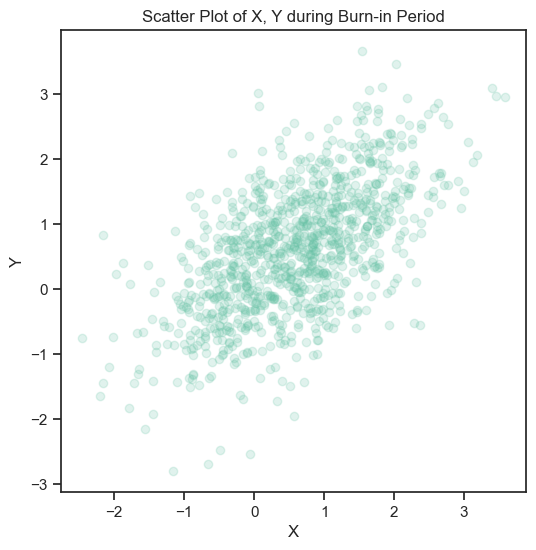

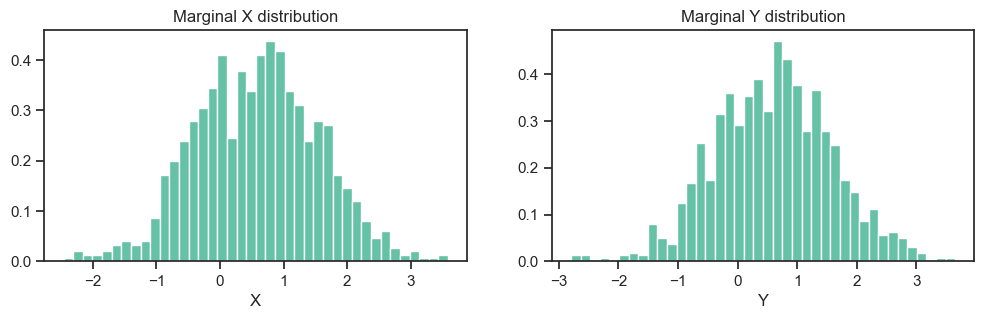

In [6]:
# Burn-in period (0.5 * total chain length)
burn_in = int(0.5 * chain_length)

# Generate the samples
random_points = np.random.multivariate_normal(mean=mu, cov=sigma, size=burn_in)

# Plot the scatter plot for the burn-in period
plt.figure(figsize=(6, 6))
plt.scatter(random_points[:burn_in, 0], random_points[:burn_in, 1], alpha=0.2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of X, Y during Burn-in Period')
plt.show()

plot_marginals(random_points)


> Examine you plot and answer these questions. 
> 1. How can you describe the tail sample and how can you explain the reason for the 'trail' given the initial sample value?  
> 2. What evidence do you see that the sampling is converging toward the actual distribution of these data values?   

 > **Answers:**     
> 1. The tail sample is characterized by the initial wandering of the Markov Chain as it starts from the initial sample value. This wandering occurs because the chain starts from a potentially arbitrary point in the state space, and it takes some time for the chain to converge to the high-probability regions of the distribution.     
> 2. The marginal distributions during the burn-in period are starting to take the shape of normal distributions, but they are not fully converged, as evidenced by the slight irregularities and deviations from perfect symmetry.

> As the number of iterations increases, the scatter plot becomes more concentrated in the high-probability region (center of the distribution), and the marginals begin to resemble the true underlying distribution more closely, indicating convergence toward the actual distribution.

> **Exercise 29-5:**  Next, plot the density of the marginal distributions for X and Y of the MCMC samples beyond the burn-in period. 

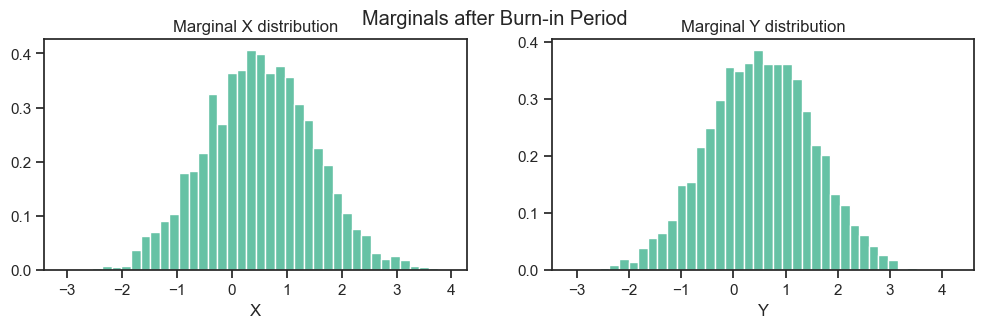

In [7]:
# We generate the same random points as before
random_points = np.random.multivariate_normal(mean=mu, cov=sigma, size=5000)

# Define the function to plot marginal distributions beyond the burn-in period
def plot_marginals_after_burnin(x, burn_in, title="Marginals after Burn-in Period"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    ax[0].hist(x[burn_in:, 0], density=True, bins=40)
    ax[0].set_title('Marginal X distribution')
    ax[0].set_xlabel('X')
    ax[1].hist(x[burn_in:, 1], density=True, bins=40)
    ax[1].set_title('Marginal Y distribution')
    ax[1].set_xlabel('Y')
    fig.suptitle(title)
    plt.show()

# Call the function to plot the marginals after the burn-in period
plot_marginals_after_burnin(random_points, burn_in)


> Compare your plots of the MCMC sample marginal distributions with the marginal distribution of the original data samples you examined for Exercise 29-3. Do the MCMC sample marginal distributions look reasonably similar to the marginal distributions of the original data samples? If not, what differences do you see?      

> **Answer:** Yes, reasonably similar. However, the distributions are still not as smooth (as normal) as the original data samples, given this is an efficient probabilistic approximation.    

> **Exercise 29-6:** Next, you will compare the **Maximum a posteriori or MAP** point of the sampled marginal distributions to the original means for $X=0.5$ and $Y=0.5$. Using the [Numpy mean function](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) and [numpy.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) compute and display an approximation of the MAP  and the Euclidean norm of the error for the MCMC sampled distributions:   
> 1. All samples.      
> 2. Samples in the burn-in period.     
> 3. Samples after the burn-in period.     

In [8]:
import numpy.linalg as la

# Define the true mean
true_mean = np.array([0.5, 0.5])

# Function to compute MAP and Euclidean norm of the error
def compute_map_and_error(samples, true_mean, description=""):
    map_estimate = np.mean(samples, axis=0)  # MAP is approximated by the mean here
    error = la.norm(map_estimate - true_mean)
    
    print(f"{description} MAP Estimate: {map_estimate}")
    print(f"{description} Euclidean Norm of the Error: {error}")
    print("-" * 50)

# Compute for all samples
compute_map_and_error(random_points, true_mean, description="All Samples")

# Compute for samples in the burn-in period
compute_map_and_error(random_points[:burn_in], true_mean, description="Burn-in Period Samples")

# Compute for samples after the burn-in period
compute_map_and_error(random_points[burn_in:], true_mean, description="Post Burn-in Period Samples")


All Samples MAP Estimate: [0.5096011  0.51884818]
All Samples Euclidean Norm of the Error: 0.021152662743366673
--------------------------------------------------
Burn-in Period Samples MAP Estimate: [0.52366859 0.53894696]
Burn-in Period Samples Euclidean Norm of the Error: 0.04557486183128259
--------------------------------------------------
Post Burn-in Period Samples MAP Estimate: [0.50608422 0.51382349]
Post Burn-in Period Samples Euclidean Norm of the Error: 0.01510320086355607
--------------------------------------------------


> Compare the results of your MAP estimates to the original data with $X = 0.5$ and $Y = 0.5$ and answer these questions. 
> 1. Does the MAP estimate, excluding the burn-in period, appear to be a reasonable estimate for the original data sample? 
> 2. Why does excluding the burn-in period from the MAP estimate improve it?

> **Answers:**       
> 1. Yes, it is within 0.01 of the actual MAP estimate.    
> 2. This is because the burn-in period is affected by the initial sample value and has not found the stable area for convergence.

### Convergence and sampling efficiency of MCMC

Let's turn our attention to the convergence properties of the M-H MCMC sampler. While convergence of MCMC sampling to the underlying distribution generally occurs, it can be slow. Unfortunately, it is not unusual for convergence to be too slow to be of practical use. Further, in some pathological cases, convergence may not occur at all.  

The **acceptance rate** and **rejection rate** are key convergence statistics for the M-H algorithm. A low acceptance rate and high rejection rate are signs of poor convergence. Likewise, too few rejections, indicate that the algorithm is not exploring the parameter space sufficiently. The trade-off between these statistics is controlled by the dispersion of the sampling distribution. This hyperparameter is generally determined by trial and error. Unfortunately, there are few useful rules of thumb one can use.     

In [9]:
print('Acceptance rate = %.2f' % (accept_count / chain_length))
print('Rejection rate = %.2f' % (reject_count / chain_length))

Acceptance rate = 0.81
Rejection rate = 0.19


These statistics indicate good convergence with a reasonable rejection rate.

Another way to evaluate the convergence of MCMC algorithms is to look at the **trace** of the samples. The trace is a plot of the sample value with sample number. The code in the cell below plots the trace for both the $x$ and $y$ samples, including the burn-in period. Execute this code and examine the results. 

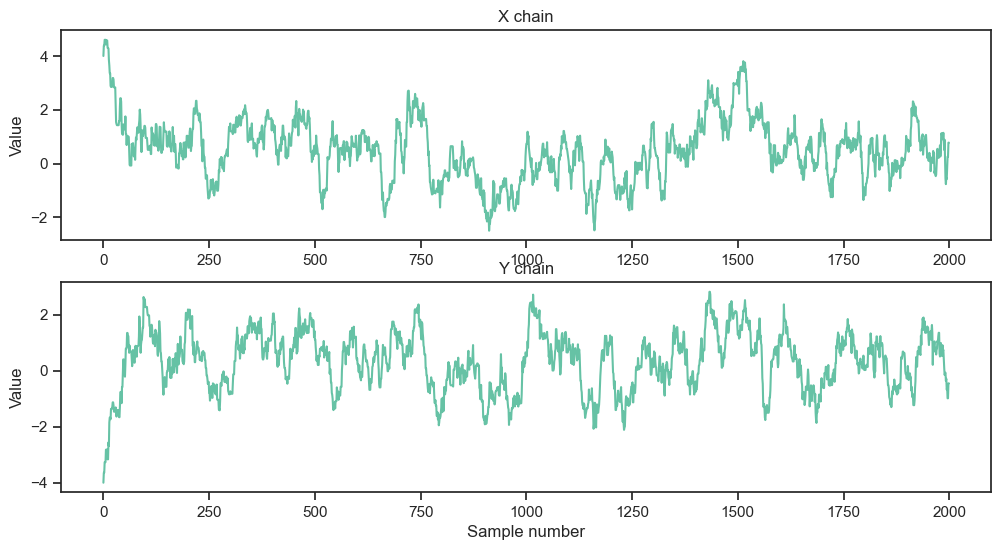

In [10]:
def plot_traces(x):
    fig, ax = plt.subplots(2, 1, figsize=(12,6))
    ax[0].plot(x[:, 0])
    ax[0].set_title('X chain')
    ax[0].set_ylabel('Value')
    ax[1].plot(x[:, 1])
    ax[1].set_title('Y chain')
    ax[1].set_xlabel('Sample number')
    ax[1].set_ylabel('Value')

plot_traces(chain)

Examine these sample traces. The nature of these plots gives insight into the progression of the MCMC sampling. Notice that there is a significant excursion during the initial burn-in period. After the initial burn-in you can see that the sampling wanders around the mode of the distribution, as it should. 

> **Exercise 29-7:** You will now look at a close-up view of the traces just after the burn-in period. Create the code in the cell below to make trace plots of samples beyond the burn-in period. Execute your code and examine the results. 

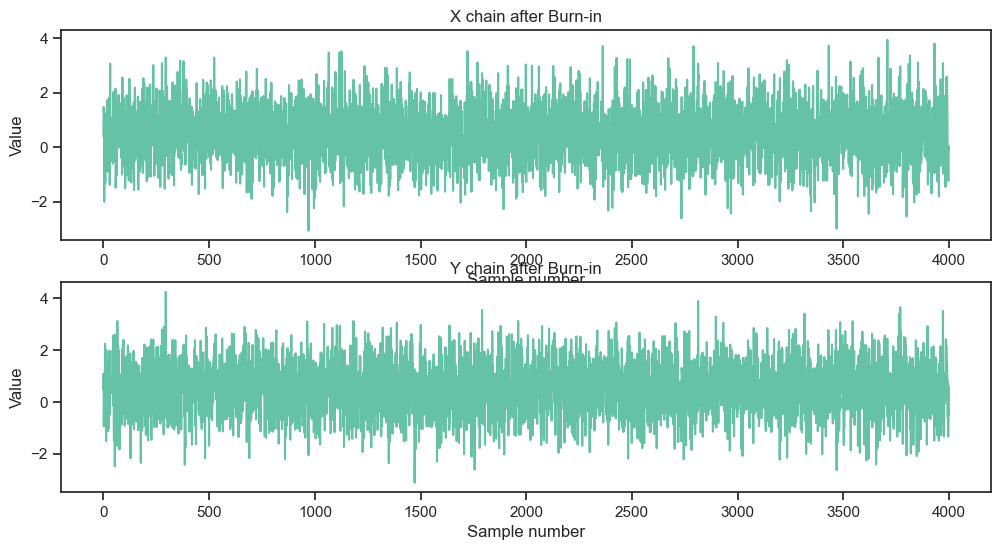

In [11]:
# Plot trace samples beyond the burn-in period
def plot_traces_after_burnin(x, burn_in):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    ax[0].plot(x[burn_in:, 0])
    ax[0].set_title('X chain after Burn-in')
    ax[0].set_xlabel('Sample number')
    ax[0].set_ylabel('Value')
    
    ax[1].plot(x[burn_in:, 1])
    ax[1].set_title('Y chain after Burn-in')
    ax[1].set_xlabel('Sample number')
    ax[1].set_ylabel('Value')

    plt.show()

# Assuming previous variables, plot traces after burn-in
plot_traces_after_burnin(random_points, burn_in)

> Examine your plots and answer the following questions:   
> 1. Do the samples appear to be centered around the MAP in the densest part of the joint distribution, $P(X,Y)$? 
> 2. Do you consider the foregoing behavior ideal in terms of how the M-H algorithm samples and, and why? 

> **Answers:**  
> 1. Yes, the samples in the trace plots after the burn-in period appear to fluctuate around a stable mean, which suggests that the Markov Chain Monte Carlo (MCMC) sampler has converged to the target distribution. This is indicative of the samples being centered around the Maximum A Posteriori (MAP) estimate in the densest part of the joint distribution, P(X,Y), which looks to be around something like [-0.5,0.5].
> 2. Yes, this behavior is ideal because the chains have stabilized after the burn-in period, indicating that the M-H algorithm has successfully reached the target distribution. The traces show good mixing, with no signs of the chain being stuck in local modes, which means the sampler is exploring the parameter space effectively.

Finally, let's take a look at the autocorrelation of our MCMC samples. Execute the code in the cell below, which uses the [Pandas.plotting.autocorrelation_plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.autocorrelation_plot.html) function to display the autocorrelation of each chain.   

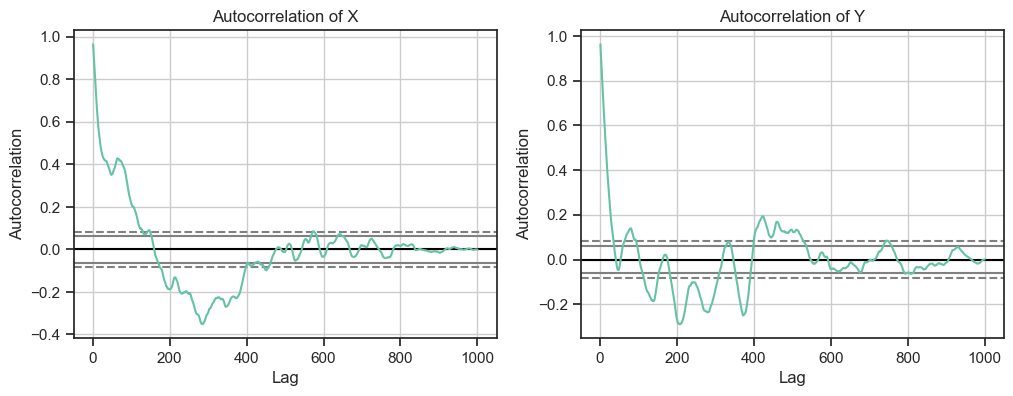

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].set_title('Autocorrelation of X');
pd.plotting.autocorrelation_plot(chain[1000:2000, 0], ax=ax[0]);
ax[1].set_title('Autocorrelation of Y');
pd.plotting.autocorrelation_plot(chain[1000:2000, 1], ax=ax[1]);

Notice that the autocorrelation dies off fairly quickly with lag. We can relate sampling efficiency to the autocorrelation of the samples. Intuitively, uncorrelated samples provide maximum information on the distribution being sampled. But, if there is significant autocorrelation, the new information gathered per-sample will be reduced, perhaps greatly so.   

We can compute an **effective sample size or ESS**. ESS is the ratio between the number of samples adjusted for the autocorrelation and the hypothetical number of uncorrelated samples. In other words, the ratio of actual vs. ideal sampling. For a sample of size $N$, and autocorrelation function at lag k$, $ACF(k)$,we compute the ESS as follows:

$$ESS = \frac{N}{1 + 2 \sum_k ACF(k)}$$    

If the autocorrelation is low, the number of effective samples is high. However, if there is significant autocorrelation the ESS will be significantly less than the actual number of samples.

We will return to this concept with an example latter in this lesson.

## Other MCMC Sampling Algorithms

Now that you have some experience with the Metropolis-Hastings MCMC algorithm, let's examine some other MCMC sampling methods. The Metropolis-Hastings algorithm is a useful tool. However, this algorithm can suffer from slow convergence for several reasons:

- Samples from the M-H algorithm generally have a fairly high serial correlation, resulting in is low ESS. 
- As already discussed, one must ‘tune’ the state selection probability distribution. For example, if we use a Normal sampling distribution we must pick $\sigma$. If $\sigma$ is too small, the chain will only search the space slowly, with small jumps. If $\sigma$ is too big, the the jumps are too large, slowing convergence.

As a result of these limimitations, quite a number of MCMC sampling methods have been proposed in a quest to improve sample efficiency. Here, we will only address a few widely used choices.   

### Gibbs sampling

The Gibbs sampler (Geman and Geman, 1984) is an improved MCMC sampler which speeds convergence. The Gibbs sampler is named for the 19th Century physicist Josiah Willard Gibbs and is inspired by statistical mechanics.   

In contrast to the M-H algorithm, the Gibbs sampler samples each dimension of the parameter space sequentially in a round-robin manner. Whereas, the M-H algorithm attempts jumps across all dimensions of the parameter space. 

The basic Gibbs sampler algorithm has the following steps:

1. For an N dimensional parameter space, $\{ \theta_1, \theta_2, \ldots, \theta_N \}$, find a random starting point. 
2. In order, $\{1, 2, 3, \ldots, N\}$, assign the next dimension to sample, starting with dimension $1$.  
3. Sample the marginal distribution of the parameter given the observations, $D$, and other parameter values: $p(\theta_1|D, \theta_2, \theta_3, \ldots, \theta_N)$.
3. Repeat steps 2 and 3 until convergence.    

From this simplified description of the Gibbs sampling algorithm you can infer:

- When compared to the Metropolis-Hastings algorithm, the Gibbs sampler reduces serial correlation through round-robin sampling. The update along each dimension approximately orthogonal to the preceding sample dimensions.    
- There are no tuning parameters since sampling is based on the marginals of the likelihood.

### No U-Turn Sampler   

The PyMC3 package uses the No U-Turn Sampler (NUTS) MCMC algorithm. NUTS uses an alternative to proposing new samples with the Metropolis-Hastings acceptance criteria or exploring dimensions in a round-robin fashion as in done for the Gibbs sampler. Instead, NUTS models the exploration as the movement of a particle through a field. In 2-dimensions, this field can be imagined to look like a hilly landscape. The high spots on the hills are the high density regions we want to sample the most. The field that guides the movement of the particle through the space is derived from the target probability distribution, such that the particle is drawn towards dense (high likelihood) regions of the space. This strategy directs the exploration of the space using the gradient, rather than using a random wandering behavior as we saw with the M-H MCMC algorithm.

The NUTS sampler is based on an earlier idea, Hamiltonian Monte Carlo. Imagine a ball in a 2-dimensional hilly landscape. The ball follows the gradient, which might send it part of the way up one of the hills. These hills represent the highest density regions of a distribution which we wish to sample. The difficulty with this idea is that one must set a number of time steps to simulate the motion of the ball. If the number of steps is too small, the algorithm will slow exploration of the parameter space. If the number of time steps is too large, the ball will jump around randomly. The original HMC method requires 2 hyperparameters to control stopping criteria of the ball. Unfortunately, in practice, setting these hyperparameters proved tricky, which limited the usefulness of HMC in practice.  

The NUTS sampler adds a simple heuristic to the HMC algorithm. The algorithm runs time both forward and backward. The point at which the forward and backward solutions meet, is the U-turn point. The number of time steps is set by finding this equilibrium point. The need for complex stopping criteria, and associated hyperparameters, is eliminated. As a result, NUTS is both a highly efficient sampler and easy to use. 

Why even discuss other samplers when we have the NUTS algorithm. Unfortunately, while NUTS works well in many common cases, it is not guaranteed to converge. For density functions with highly complex behavior, other samplers are required. In these cases, the Gibbs sampler is typically used.  

## An example: Linear Regression   

With the foregoing in mind, let's try a simple example. In this case we will try a simple regression model using synthetic data. The data have two independent (predictor) variables and one response variable. Normally distributed noise is added to the linear trend of the response variable. This example has been derived in part from the [Introductory Overview of PyMC](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html)  

Our model has 4 parameters we wish to estimate and perform inference on. We state our prior distributions for these parameters:    

\begin{align}   
\beta_0 &\sim \mathtt{N}(0, 2)\\
\beta_1 &\sim \mathtt{N}(0, 2)\\
\beta_2 &\sim \mathtt{N}(0, 2)\\
\sigma &\sim |\mathtt{N}(0, 1)
\end{align} 

Here, $\beta_0$ is the intercept term, $\beta_1, \beta_2$ are the partial slopes, $\sigma$ is the standard deviation. The notation, $|\mathtt{N}(.,.)$, indicates a **half Normal distribution**, with only values $> 0$.      

Given the two independent variables, $x_1, x_2$, and a realization of the values of $[\beta_0, \beta_1, \beta_2]$, the expected value of the response, $\mu$ is **computed deterministically** as:   

$$\mu = \beta_0 + \beta_1 * x_1 + \beta_2 * x_2$$

Finally, the values of the posterior distribution of the response variable, $Y$ are computed as:    

$$Y \sim \mathtt{N}(\mu, \sigma)$$

As a first step, execute the code in the cells below to configure the environment and to generate and display the dataset. 

In [13]:
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

# Initialize random number generation
SEED = 8927

Mean of response variable Y = 0.91
Means of independent variables, x1 = -0.09  x2=0.02


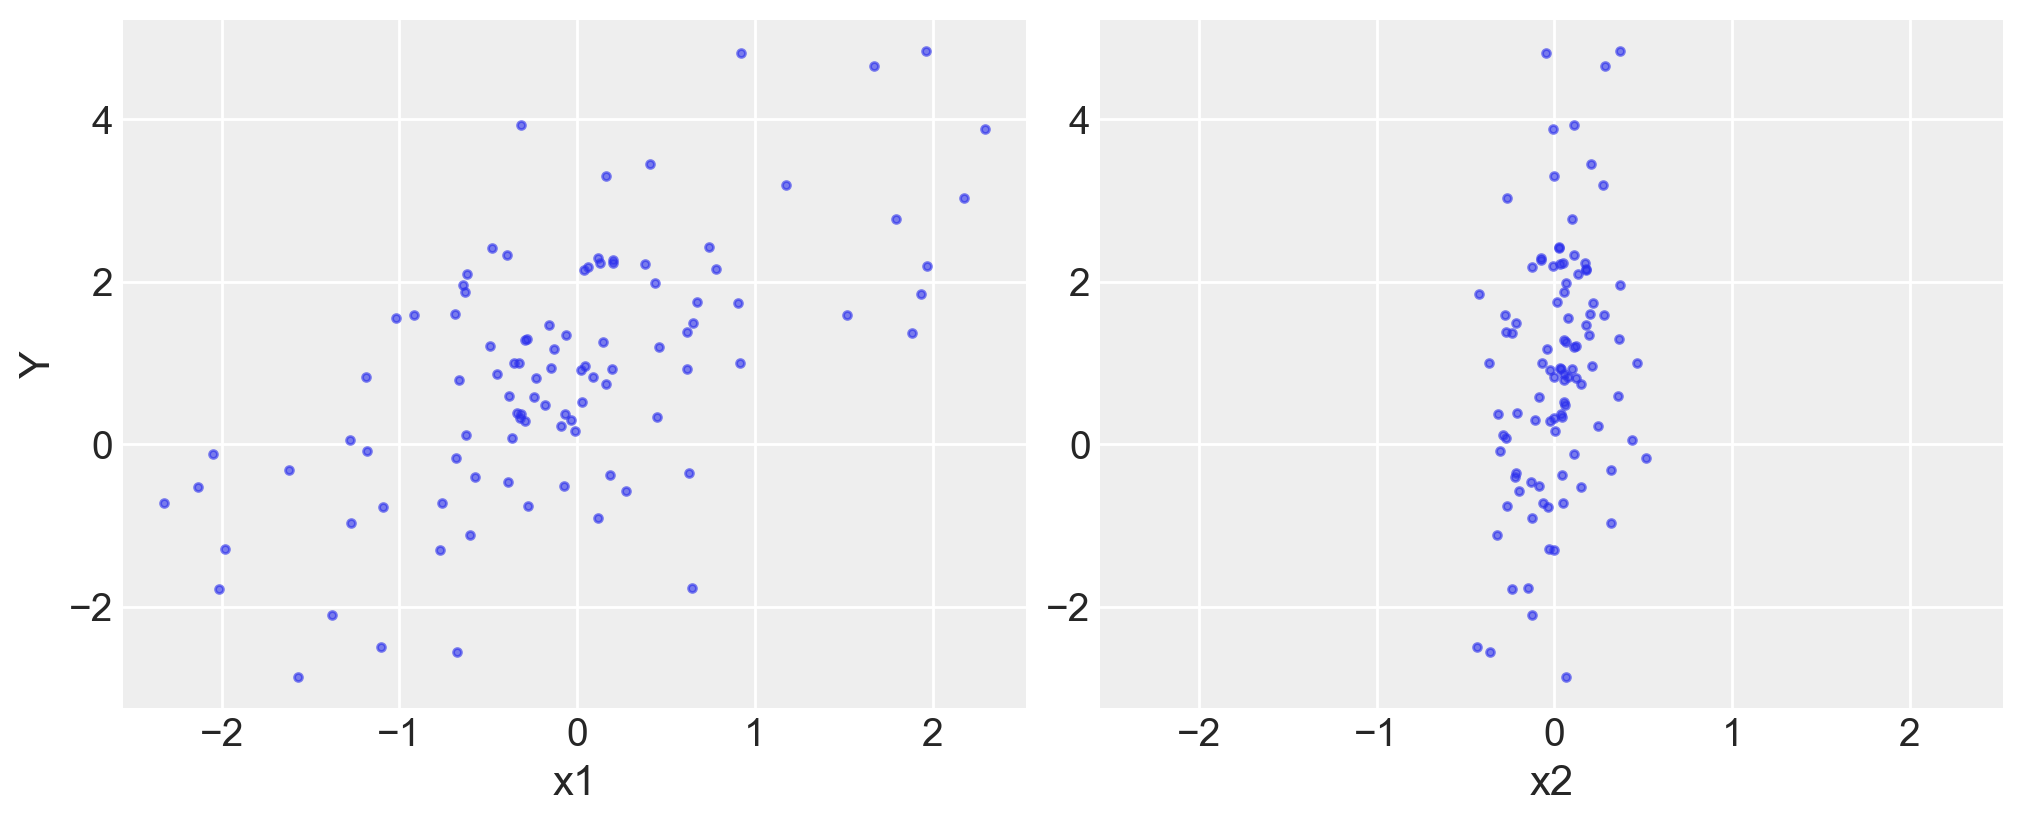

In [14]:
# True parameter values
Betas = [1.0, 1.0, 2.5]
sigma = 1.0

# Size of sample
size = 100

# Independent variables
np.random.seed(SEED)
x1 = np.random.randn(size)
x2 = np.random.randn(size) * 0.2

# Simulate dependent variable
Y = Betas[0] + Betas[1] * x1 + Betas[2] * x2 + np.random.normal(size=size) * sigma

print('Mean of response variable Y = {0:4.2f}'.format(np.mean(Y)))
print('Means of independent variables, x1 = {0:4.2f}  x2={1:4.2f}'.format(np.mean(x1),np.mean(x2)))

## Plot the simulated data  
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(x1, Y, s=8, alpha=0.6);
axes[1].scatter(x2, Y, s=8, alpha=0.6);
axes[0].set_ylabel("Y");
axes[0].set_xlabel("x1");
axes[1].set_xlabel("x2");

Examination of these plots show that noting the following:          
1. The independent have been defined so that they are **zero centered**.   
2. This is difficult problem. There relationship between $x_1$ and $Y$ shows significant dispersion. Further, it appears that $x_2$ has little if any predictive power.     

### Defining the model      

The code in the cell below defines the PyMC model which has the following steps:       
1. The priors are defined. Notice the `shape=3` argument which defines a 3-vector of the betas.    
2. The deterministic formulation of the expected value of the response variable is defined.   
3. The distribution of the response variable is defined.   

Execute the code to instantiate the model.  

In [15]:
with pymc.Model() as regression_model:
    # Priors for unknown model parameters
    betas = pymc.Normal("betas", mu=0, sigma=2, shape=3)
    sigma = pymc.HalfNormal("sigma", sigma=1)

    # Deterministic expected value of outcome
    mu = betas[0] + betas[1] * x1 + betas[2] * x2

    # Likelihood (sampling distribution) of observations
    Y_obs = pymc.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

###   Prior predictive checks

Before we get started with MCMC sampling and inference, we must verify that we are satisfied with priors.   

To start, execute the code in the cell below to compute prior check samples.    

In [16]:
SEED = 3434
with regression_model:
    prior_checks = pymc.sample_prior_predictive(samples=50, random_seed=SEED)
prior_checks.keys()

Sampling: [Y_obs, betas, sigma]


KeysView(Inference data with groups:
	> prior
	> prior_predictive
	> observed_data)

There are several variables we will investigate. First we should compare the prior of the response density to the actual observed density. To do so, execute the code in the cell below and examine the results. The complex reference to the prior density arrises from PyMCs use of the [ArvidZ inference data structures](https://python.arviz.org/en/latest/schema/schema.html).   

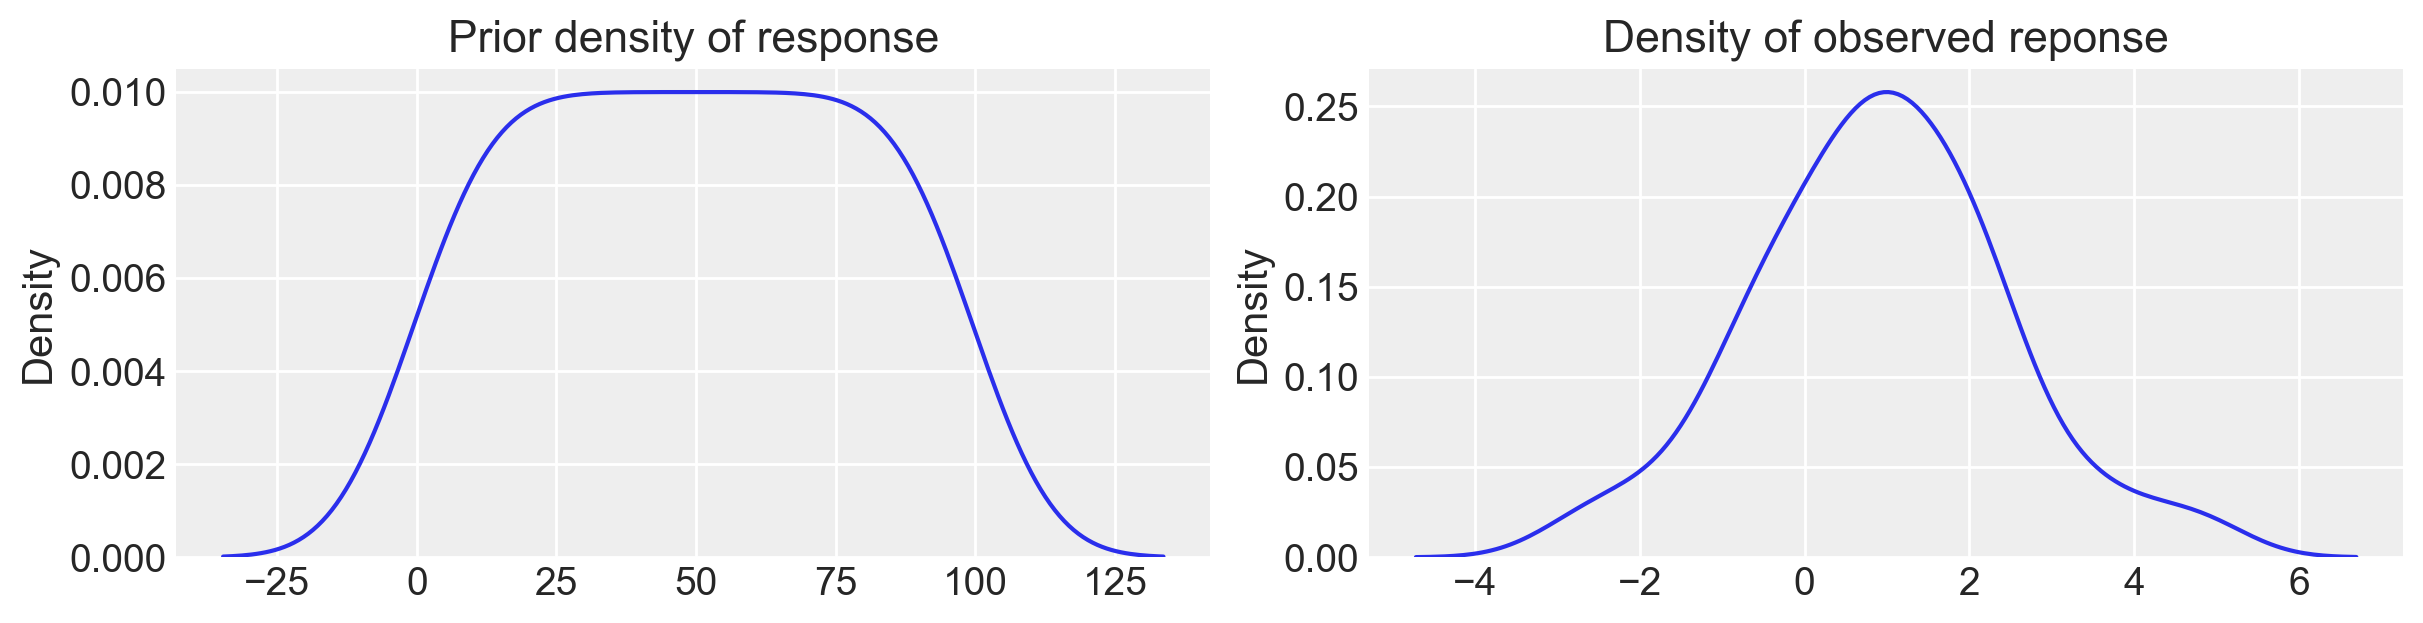

In [17]:
_,ax=plt.subplots(1,2, figsize=(12,3))
ax = ax.flatten()
sns.kdeplot(prior_checks['prior_predictive'].to_array()['Y_obs_dim_0'], ax=ax[0]);
#sns.kdeplot(prior_checks['prior'].to_array()[1,0,:,1], ax=ax[0]);
ax[0].set_title('Prior density of response');
sns.kdeplot(Y, ax=ax[1]);
ax[1].set_title('Density of observed reponse');

Comparing these densities one can see that the dispersion of the prior density is greater than the actual response. This is not unexpected or undesirable. If the prior was less dispersed it would restrict the posterior. This observation indicates that the prior is not very informative. Overall, we are satisfied with this prior density.     

Next, display and then examine density plots of the priors for the model parameters by executing the code in the cell below. 

array([[<Axes: title={'center': 'betas\n0'}>,
        <Axes: title={'center': 'betas\n1'}>,
        <Axes: title={'center': 'betas\n2'}>],
       [<Axes: title={'center': 'sigma'}>, <Axes: >, <Axes: >]],
      dtype=object)

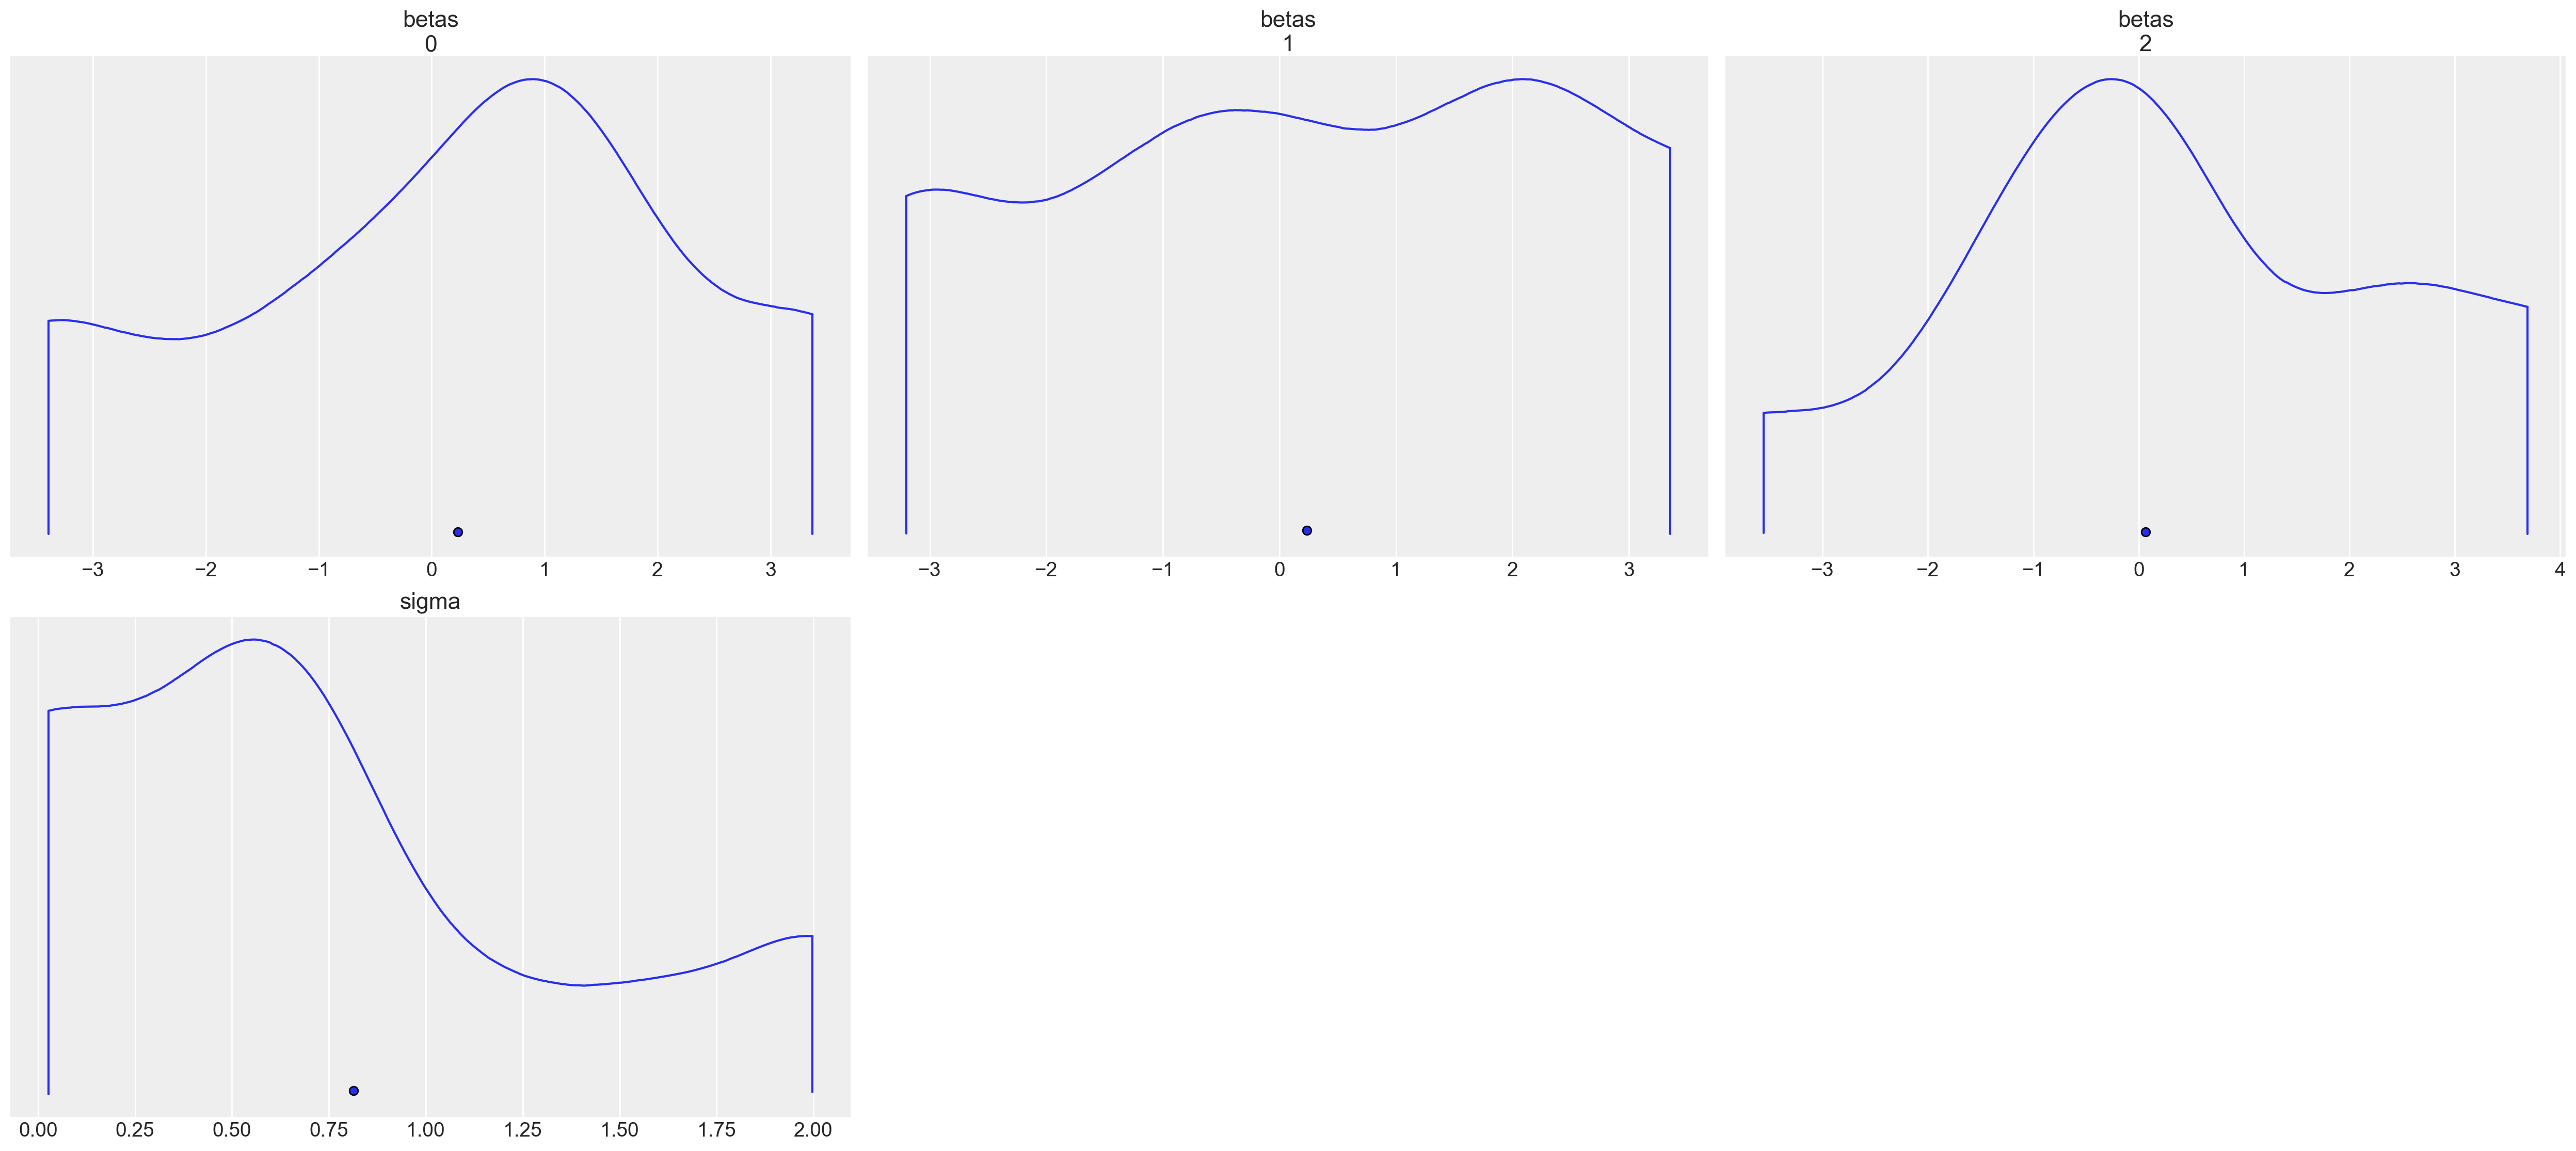

In [18]:
az.plot_density(prior_checks, group='prior')

These densities look reasonable, with no apparent undesirable behavior, but with wide (high) dispersion. Again, wide dispersion of the priors desirable, so as not to overly restrict the posterior. The negative values of the density of $\sigma$ are an artifact of the kernel density estimation.     

### MCMC sampling and inference       

Now that we are satisfied with the priors, we are ready to MCMC sample the model. Execute the code in the cell below to do so.   

In [19]:
with regression_model:
    np.random.seed(1414)
    # 1000 posterior sample draws
    idata = pymc.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Now that the traces are computed, execute the code in the cell below to display the densities and the trace plots.  

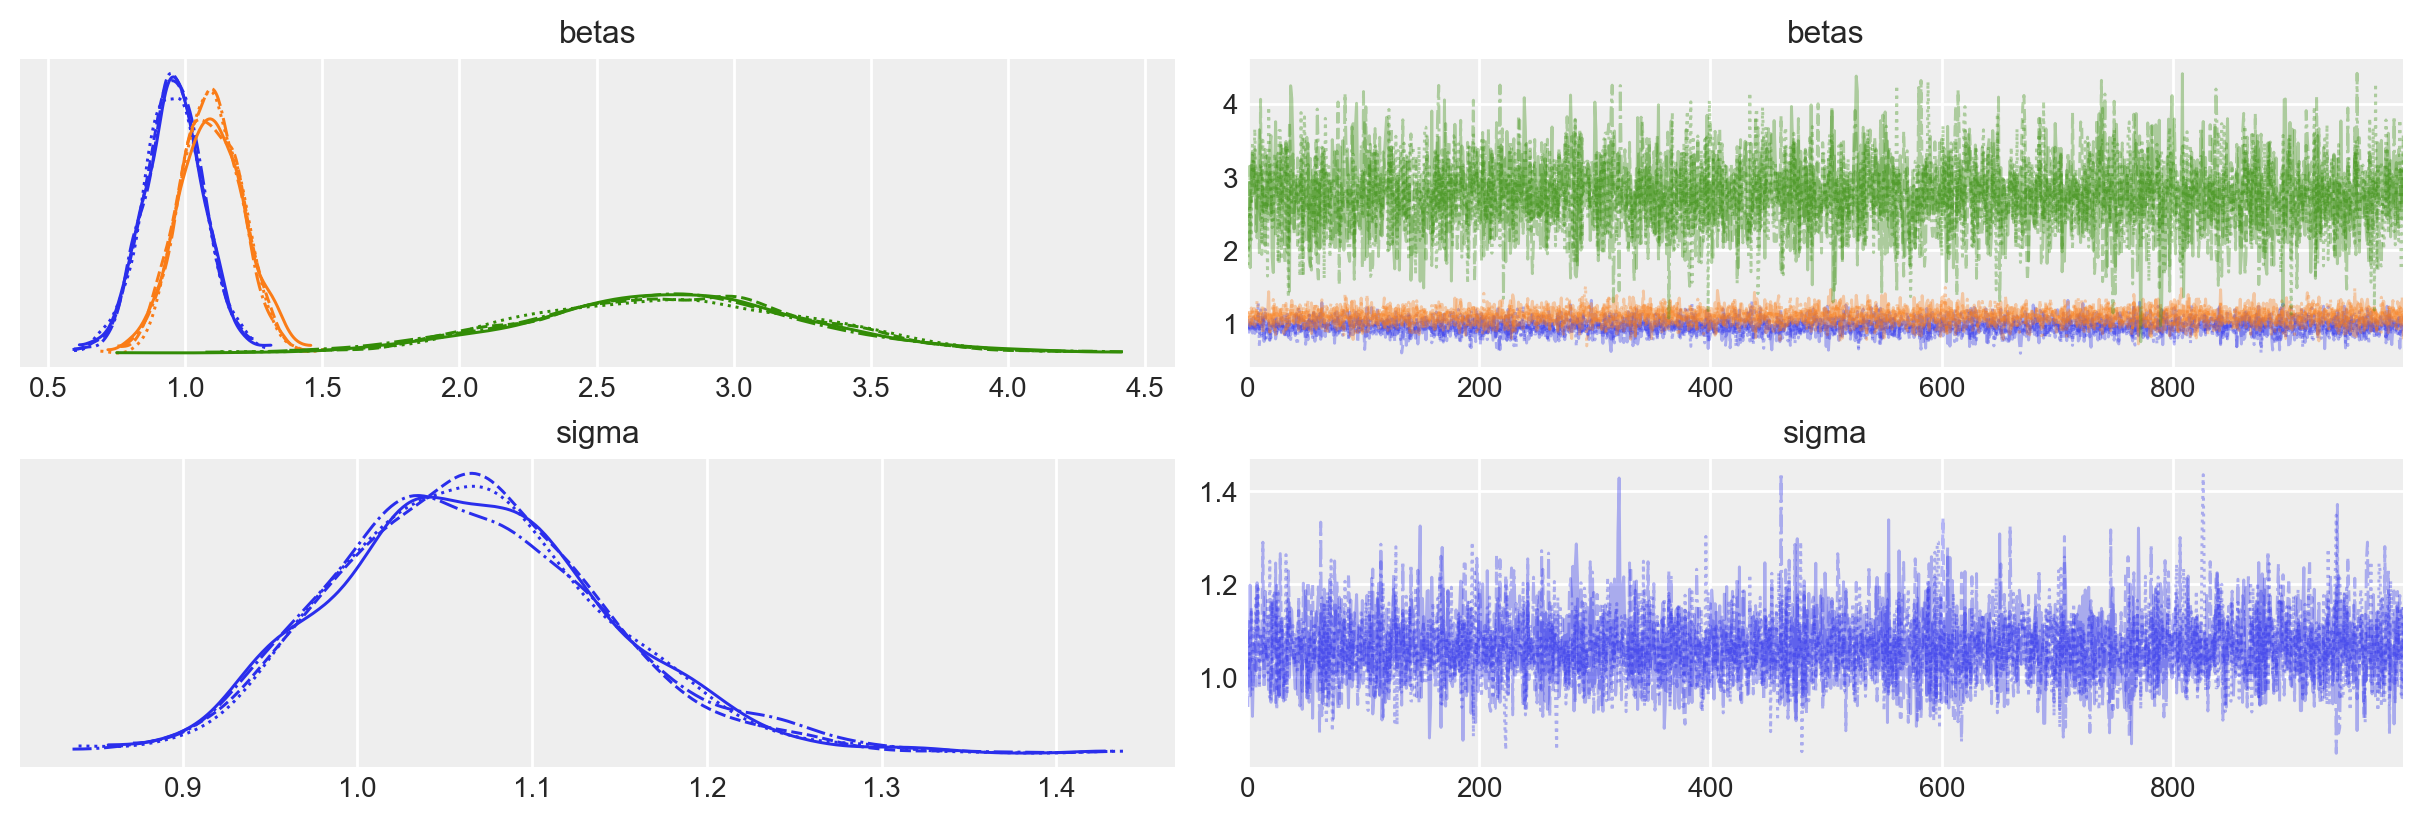

In [20]:
az.plot_trace(idata, combined=False);

Examine the plots and notice the following:     
1, The posterior density of the betas looks reasonable.    
2, The multiple traces for each of the betas overlap and have nearly constant dispersion. This indicates good convergence of the MCMC sampling.    
3. The density and traces of $\sigma$ have similar desirable properties as the betas.  

The forest plot displays the HDI computed from each trace for each of the model parameters. Execute the code in the cell below to display this plot and examine the results.     

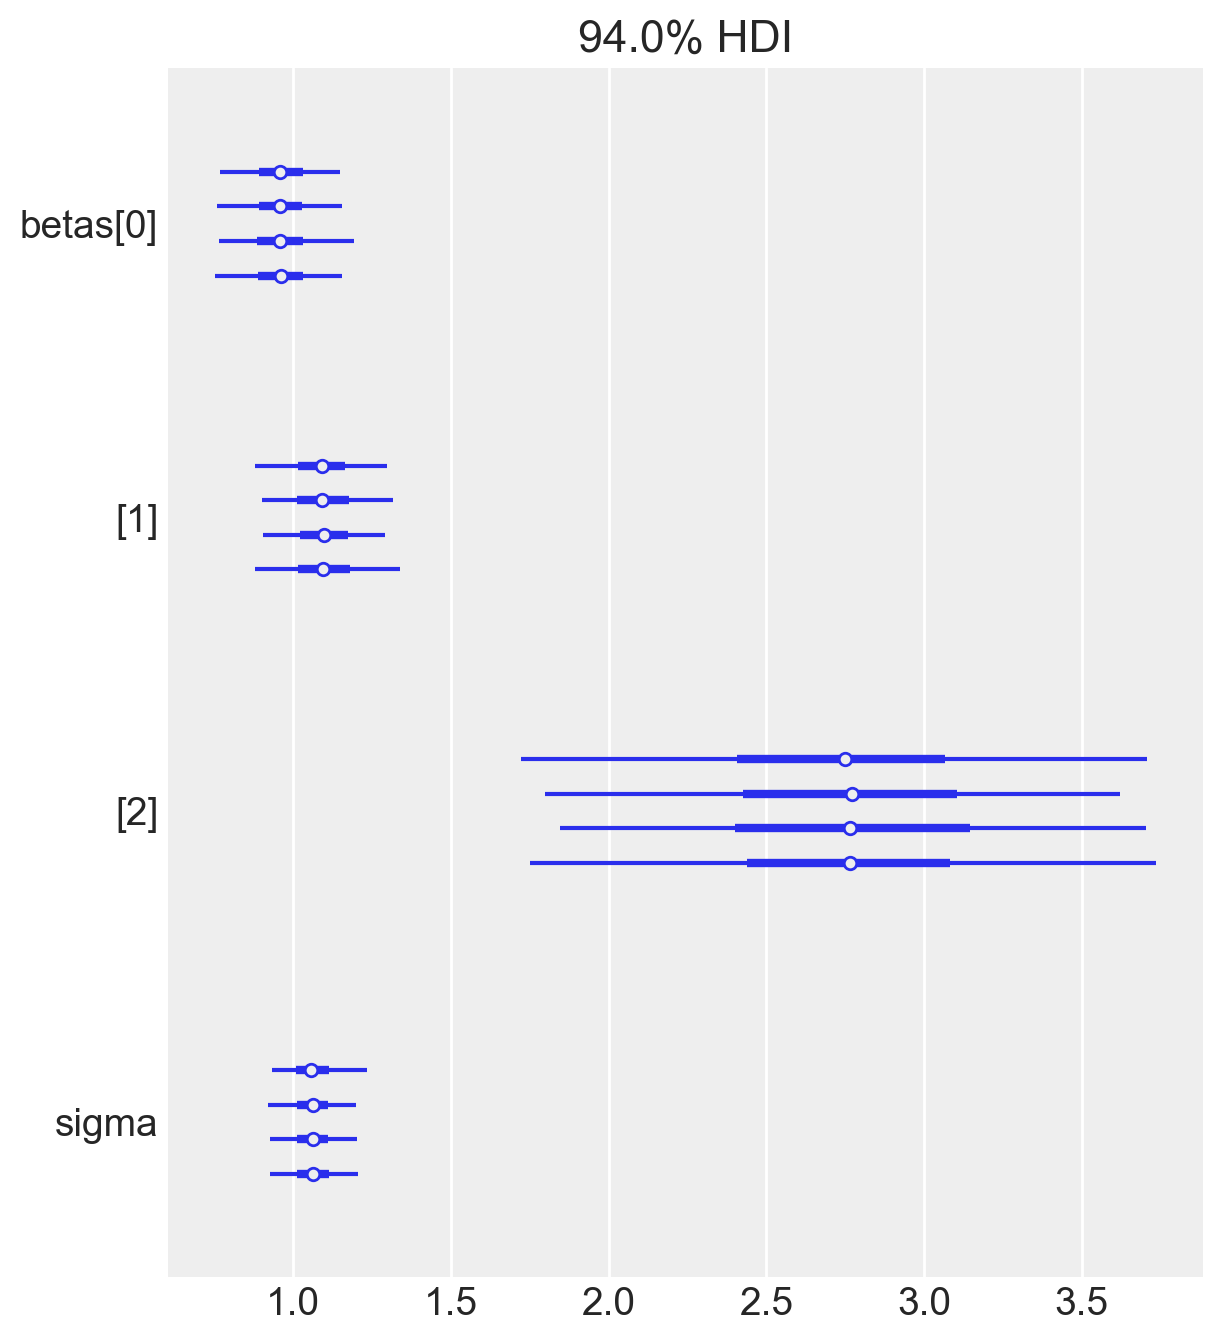

In [21]:
az.plot_forest(idata, var_names=["betas", "sigma"]);

Notice that the HDI is very similar for all traces for each of these model parameters. This fact further indicates good convergence of the MCMC sampling. The values appear reasonable as well.              

Execute the code in the cell below to display the density and HDI for the model parameters integrated over the MCMC traces.    

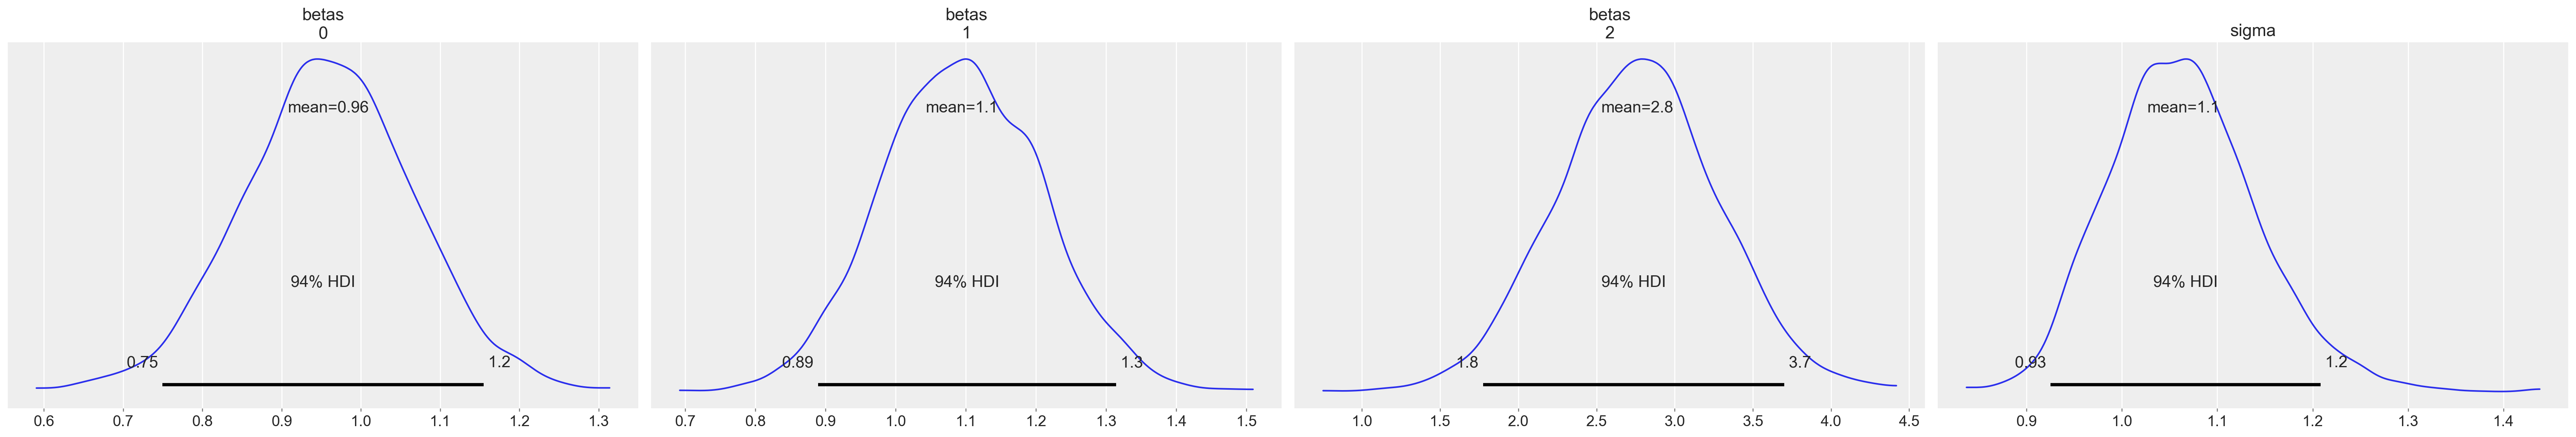

In [22]:
az.plot_posterior(idata, var_names=["betas", "sigma"]); 

One can see that these posterior distributions are approximately Normal, but with some skewness and heavy tails. The HDIs confirm that two $\beta$s and $\sigma$ are well determined and third $\beta$ is not. The HDI of $\beta_2$ has a range from about 1.3 to about 3.2. This means that a small change in $x_2$ can lead to a large change in the response with high uncertainty.            

### Sampling     

The posterior distribution of the parameters seems promising. We now need to perform analysis of the sampling and some posterior checks. We will start with analysis of the sampling.   

A first step to check the sampling execute the code in the cell below to print a summary table of some sampling statistics.      

In [23]:
az.summary(idata, kind='diagnostics')

mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
betas[0]      0.001    0.001    6200.0    2787.0    1.0
betas[1]      0.001    0.001    6029.0    3211.0    1.0
betas[2]      0.007    0.005    5714.0    3330.0    1.0
sigma         0.001    0.001    6815.0    3256.0    1.0

The summary shows a lot of useful information for each parameter estimate:      
1. The mean MCMC error of the posterior distribution of each coefficient value. This estimated error tells us how much error the MCMC sampling has introduced.        
2. The standard deviation (`sd`) of the mean error of the posterior distribution of the coefficient values. 
3. Next come metrics of **effective sample size (ESS)**. First the middle portion of the posterior distribution and then the tail ESS. We have already discussed the concept of effective sample size. These metrics give indications of overall ESS alone with specific metrics for the bunk of the posterior distribution and its tails. These statistics are reported with respect to the total number of samples in all chains.    
6. The **Gelman-Rudin statistic** (`R_hat`) (Gelman and Rubin, 1992) measures the ratio of the **variance shrinkage between chains** to the **variance shrinkage within chains**. The Gelman-Rudin statistic should converge to 1.0. That is, if all chains converge, the reduction in variance between chains and within the chains should be the same.   

Keeping in mind that there are 1000 samples per trace, you can see that ESS is generally good for these parameters. Further, the standard error and `r_hat` are quite good.        

To further investigate the MCMC error and the ESS we can create plots by quantiles of the posterior of the parameters. Execute the code in the cell below and examine the results.      

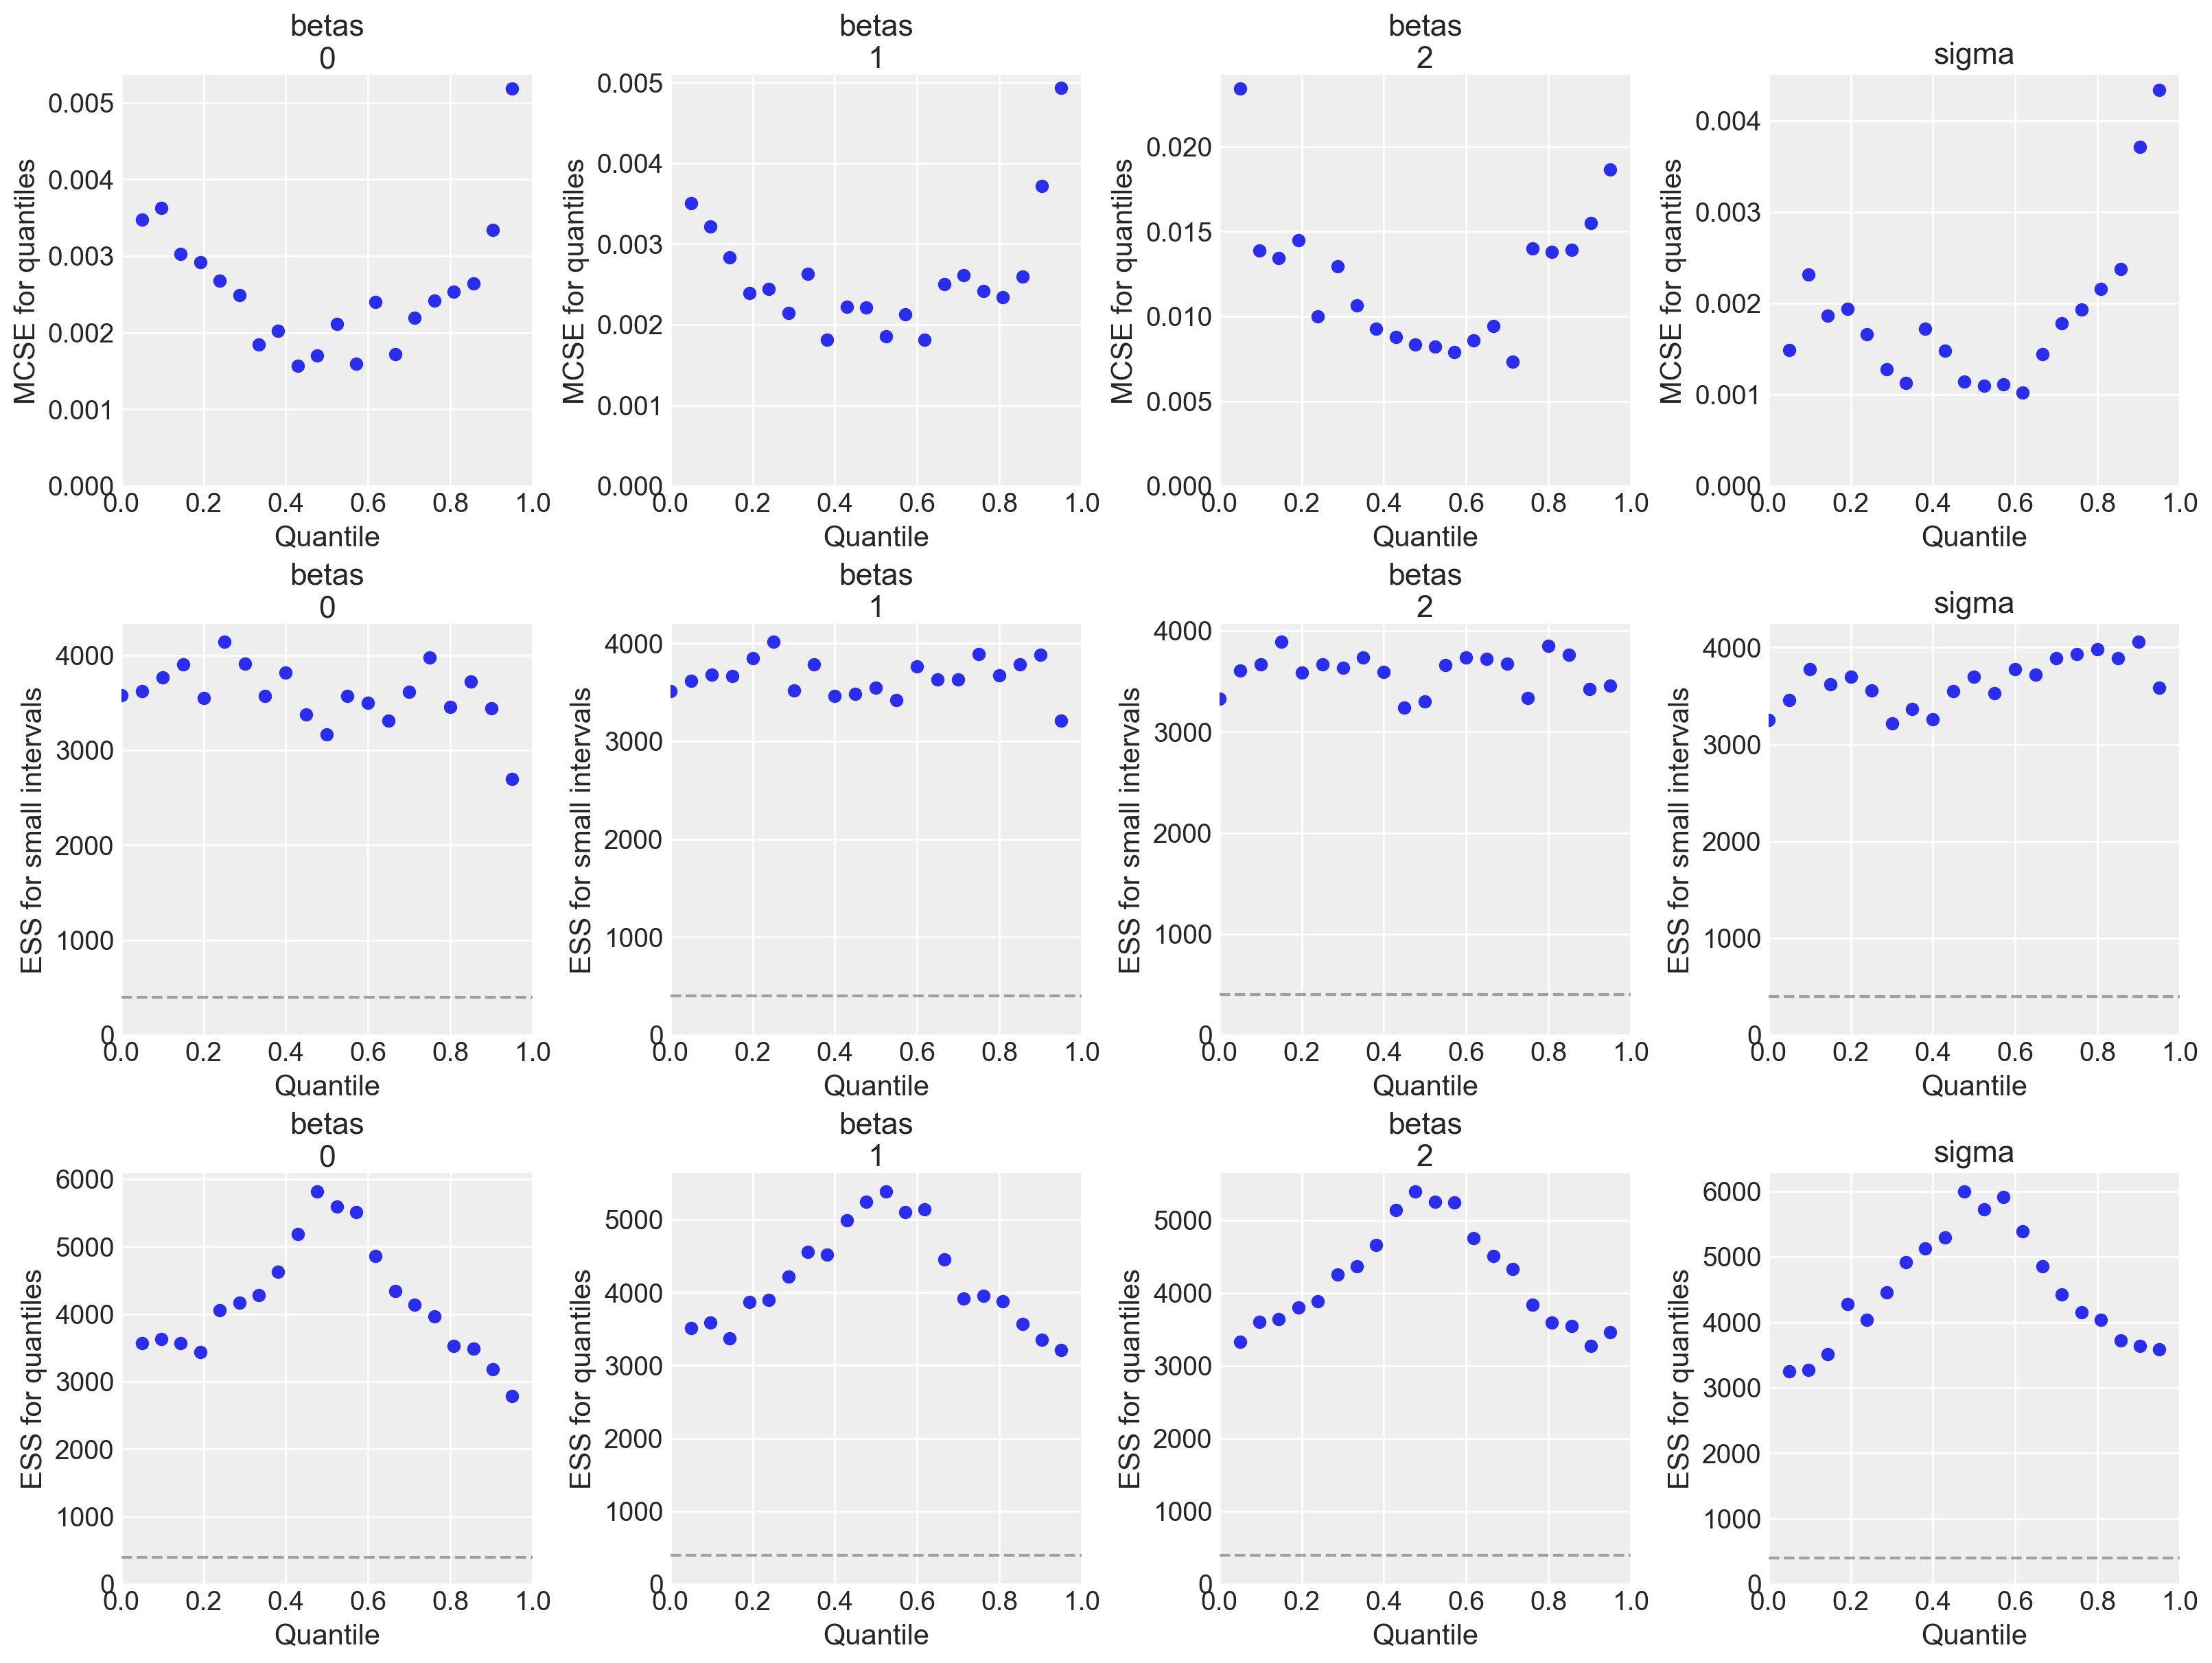

In [24]:
_,ax = plt.subplots(3,4, figsize=(16,12))
az.plot_mcse(idata, ax=ax[0])
az.plot_ess(idata, kind="local", ax=ax[1]);
az.plot_ess(idata, kind="quantile", ax=ax[2]);

Notice the following about these plots:     
1. The MCSE is generally small across all quantiles of all parameters. However, MCSE increases at the extreme quantiles, likely as a result of lower sampling density in the tails of the distribution.    
2. The local ESS is large compared to the total number of samples in the chains and fairly constant over the quantiles.        
3. The quantile ESS is lower at the outer quantiles. Again, this may be a result of limited sample in the tails and dense sampling in the middle part of the distribution.      

Overall, these results look satisfactory.   

### Posterior checks   

To complete this analysis we must perform the posterior checks. The goal of these checks is to verity that the posterior distribution of the response matches the observations reasonably well. Posterior predictive checks use statistics based on the on **posterior predictive distribution**. Since we do not know the true posterior distribution we approximate the posterior predictive distribution using by resampling from the posterior distribution:    

$$p(y^{rep}|y)= \sum_i p(y^{rep}|\theta) p(\theta|y)$$

Where:   
$y^{rep} =$ realization drawn from the posterior distribution  
$y =$ observation  
$p(y^{rep}|\theta) =$ draw from posterior distribution with parameters $\theta$    
$p(\theta|y) =$ posterior distribution of model parameters, $\theta$    


Now, execute the code in the cell below to sample the response variable from the posterior distribution.   

In [25]:
SEED = 6545
with regression_model:
    pymc.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=SEED) 

Sampling: [Y_obs]


Output()

With the posterior predictive samples computed, we can now start the posterior predictive checks.   

The first step in the posterior checks is to display the posterior density of the response along with the density of the observed response. Execute the code in the cell below to display the plot.     

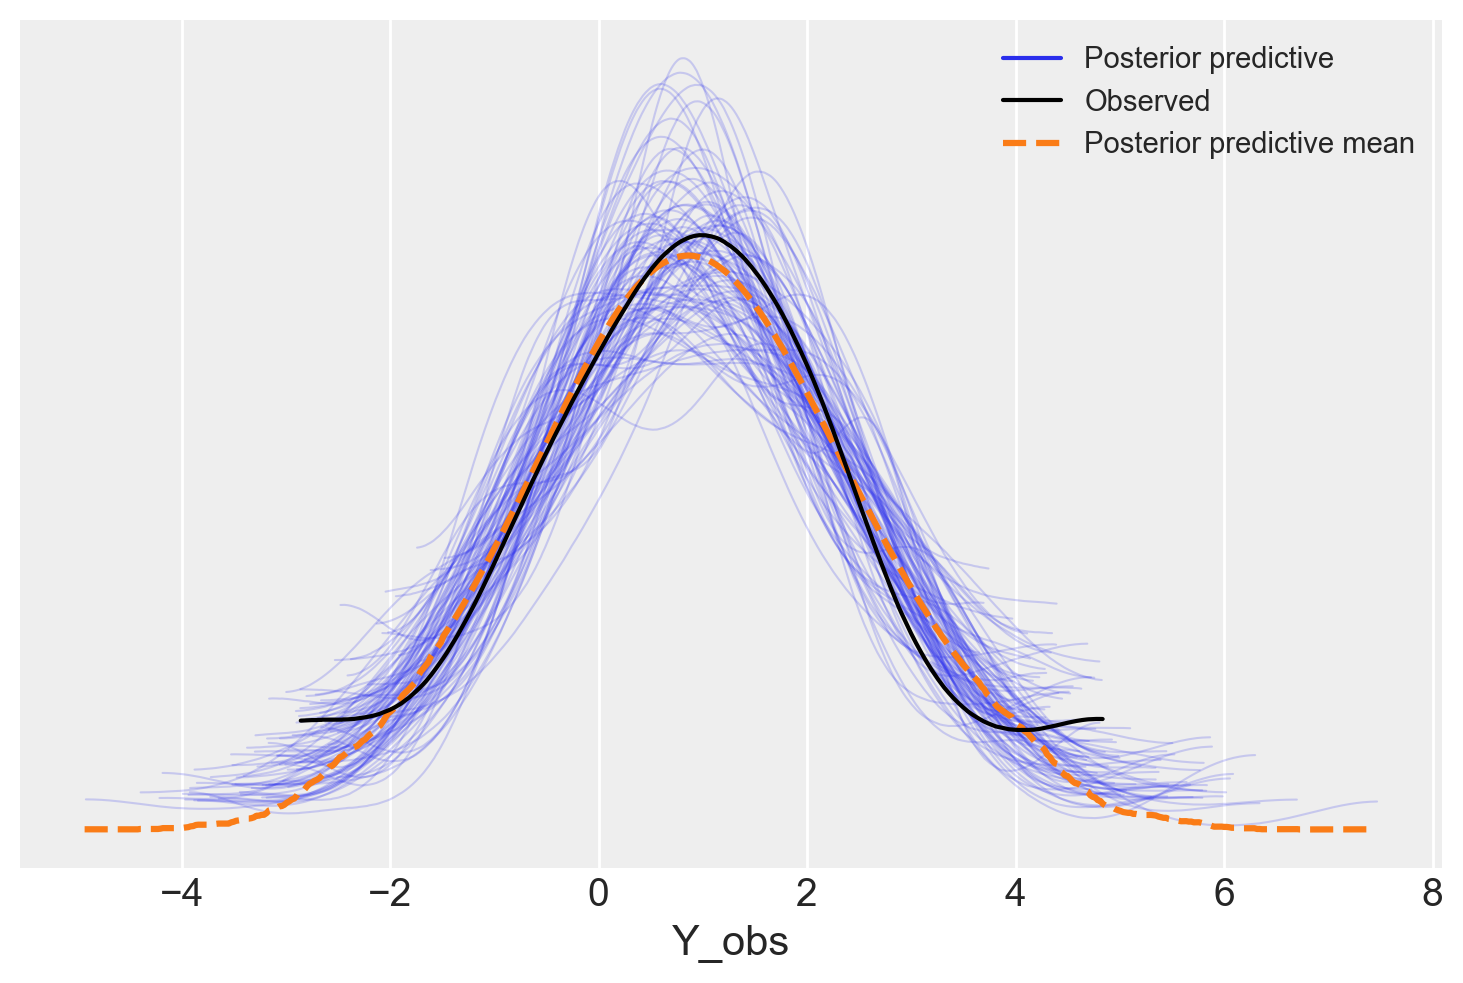

In [26]:
az.plot_ppc(idata, num_pp_samples=100);

Examine this plot. Notice the following:    
1. The mean posterior predictive and the observed curves are fairly similar. The observed density seems to have more weight in the tails and a bit of right skew, meaning that the mean posterior predictive has a lower probability of forecasting these values.    
2. There is considerable dispersion for the posterior predictive distribution.     

Next, we will evaluate the **Bayesian p-value** test statistic, $T$, for the distribution differences between observed and predicted responses. This statistic is formulated:  

$$p = p(y^{rep} < y | y )$$
  
Intuitively, the posterior predictive Bayesian p-value should be symmetric and centered on $p = 0.5$, over many draws of $y^{rep}$. In other words, we expect the following behavior:      
- $y^{rep} < y | y$ half the time    
- $y^{rep} > y | y$ half the time    
   
To display the density of the Bayesian p-value, execute the code in the cell below.     

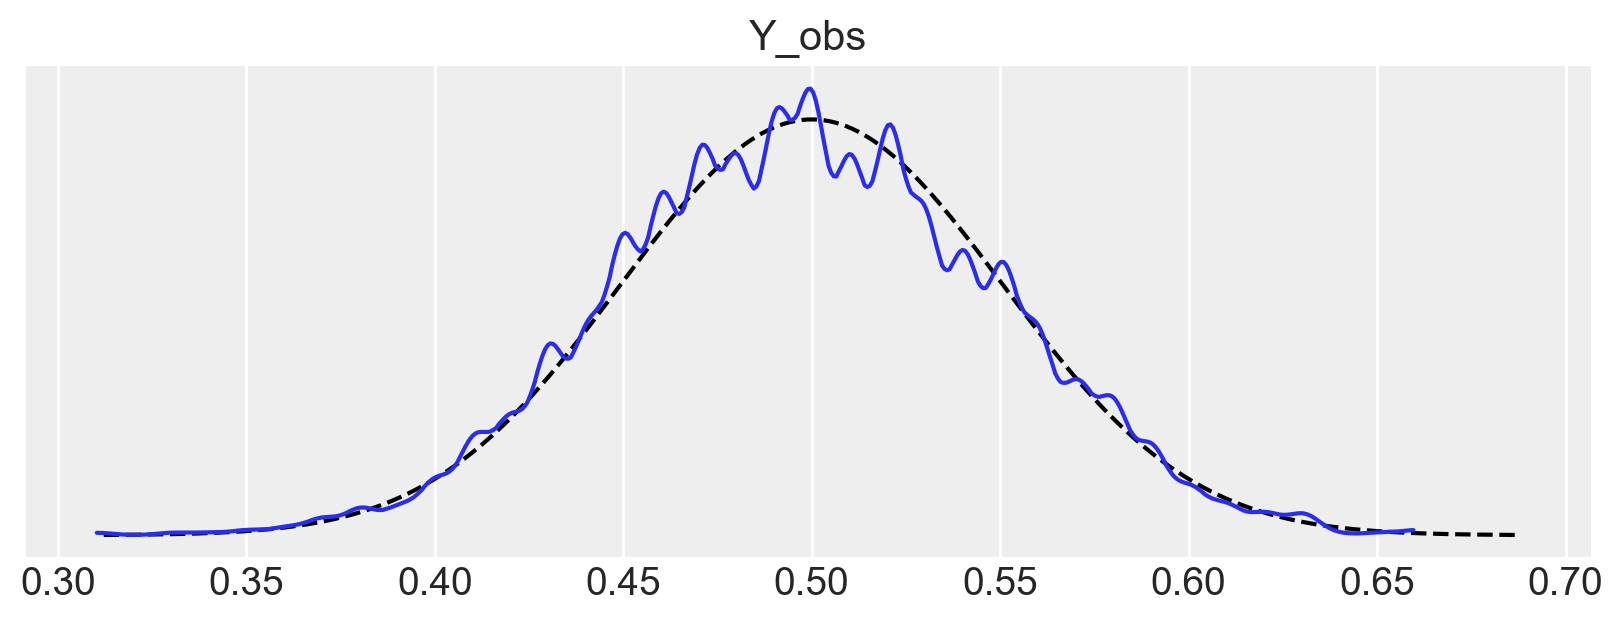

In [27]:
_,ax = plt.subplots(figsize=(8,3))
az.plot_bpv(idata, kind='p_value', ax=ax);

Examine the plot. The dotted line is the ideal density, centered at $p =0.5$. The empirical density of the Bayesian p-value is shown by the blue line. The blue line is very nearly the same as the dotted line indicating that the density of $p$ is close to the desired behavior of posterior predictive values.   

Another statistic is the posterior predictive **Bayesian u-value**, also known as the **marginal p-value**. This statistic can is defined:        

$$p_i = p(y_i^{rep} < y_i | y )$$

The U-value computed for specific (ordered) observation $y_i$, with the following properties:       
- $p_i$ should be centered on 1.0    
- $p_i$ should be close to uniformly distributed    

Execute the code in the cell below to display the Bayesian u-value.   

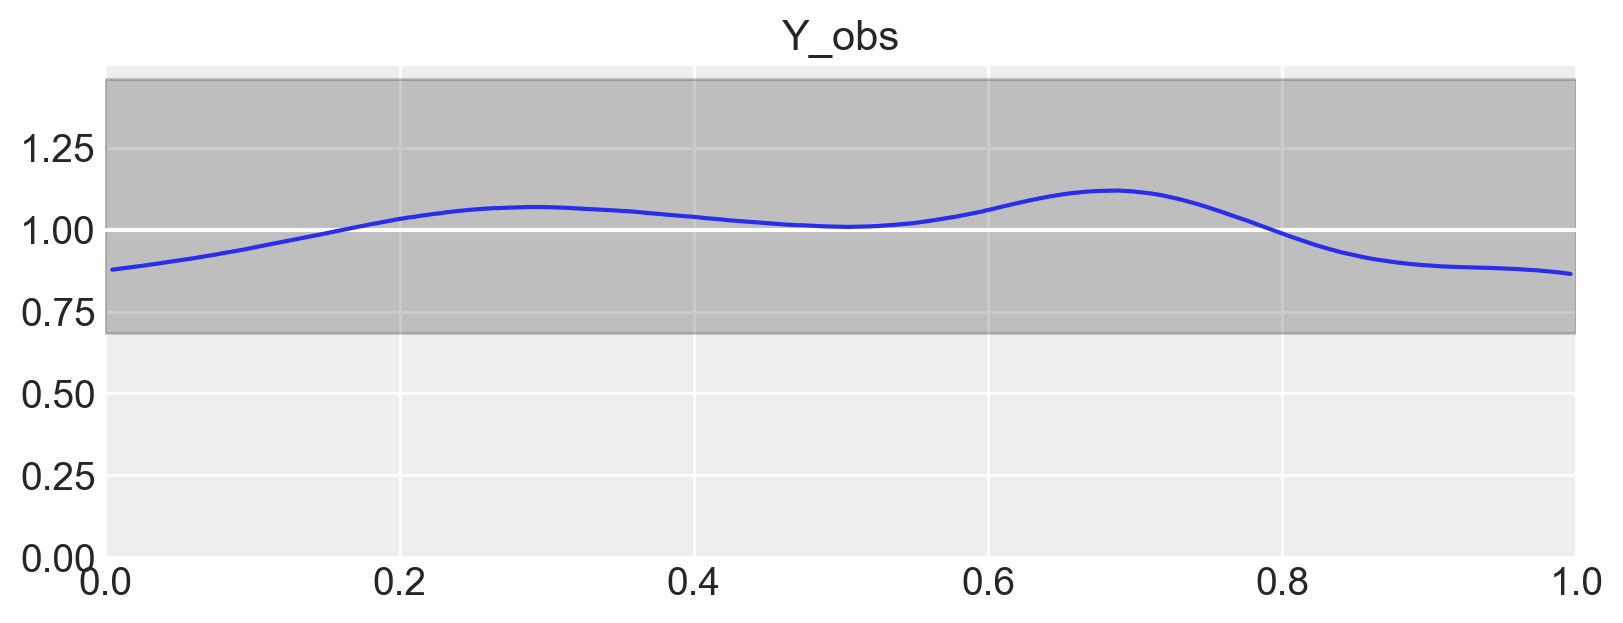

In [28]:
_,ax = plt.subplots(figsize=(8,3))
az.plot_bpv(idata, kind='u_value', ax=ax);

Examine this plot. The white line shows the ideal behavior and the shaded area is the confidence interval. The blue line is very close to the ideal. Again, this indicates the posterior predictive values have a distribution close to the actual values.       

## Example: British Coal Mine Disasters   

Toward the end of the 19th Century there was growing public awareness of the rising accidental death rate in European coal mines. A mine disaster became defined as an incident leading to 6 or more deaths. As early as 1886 a British Royal Commission published recommendations for safety practices. However, adoption of these practices remained voluntary. The [British Coal Mines Act of 1911](https://en.wikipedia.org/wiki/Coal_Mines_Act_1911) finally codified mine safety procedures into law.  

Famous data set originally published by Carlin, Gelfand, and Smith (1992) includes the number of coal mine disasters by year between 1851 and 1962. These data are available for download from [Kaggle](https://www.kaggle.com/datasets/nabamitachakraborty/coal-mine-disastersuk), and other sources.  

Our goal here is to create a model to quantify the differences in the rate of mine disasters before and after the introduction of improved safety practices. This analysis is an example of a **point process model**. A point process model has an **intensity** or **rate** of occurrence of a type of event, mine disasters in this case. The number events over a time period for this type of point process is independent and identically distributed (iid). In other words, the number of events per time period are a iid draw from some probability distribution. Because of the iid nature of the point process, there is no autoregressive (AR) effect in the time series.       

The iid nature of the point process does not mean that the distribution of the process cannot change in time. It fact, such **change points** or **switch points** in rate with time are quite common in the real-world. Identifying these change points is often a challenging problem.   

The dataset gives us the rate of mine disasters by year so the problem can be addressed as a point process model. There are two related questions we can ask about these data. First, at what point in time was there a significant change in the rate or intensity of mine disasters, the switch point? The answer is not obvious from the history since the changes in safety practice were adopted over about 25 years. The second question is how significant was the reduction in the rate of disasters over this period?      

As is common for point process models, we can try modeling the intensity of the point process using a Poisson distribution. If there is a switch point in time $s$, we can write the rate model for intensity of disasters at time t, $D_t$, as:"     

$$
D_t \sim Pois(r_t),\ r_t 
\begin{cases}
     e,\ t < s\\
     l,\ t \ge s
\end{cases}
$$

There are now three parameters we must estimate for this model, $e, l$ and $s$. To create a Bayesian model for this problem we need to come up with some prior distributions for these parameters. Let's start with some simple priors:    

\begin{align}   
s &\sim unif(t_{min}, t_{max})\\
e &\sim exp(2) \\    
l &\sim exp(2)
\end{align}   

In words, our prior for the switch point is uniform over all years in the data, and exponential distributions with mean 2 for the rates. We now have everything we need to create and test our model.  

### Load and explore the data

To get started execute the code in the cell below to load the data and display a sample.  

In [29]:
disaster_data = pd.read_csv('CoalMiningDisastersUK.csv')
disaster_data 

Year  Count
0    1851      4
1    1852      5
2    1853      4
3    1854      1
4    1855      0
..    ...    ...
107  1958      0
108  1959      0
109  1960      1
110  1961      0
111  1962      1

[112 rows x 2 columns]

There are two columns in this table, the year and the rate of mine disasters.   

Next, execute the code in the cell below to display a chart of the number of mine disasters vs. time and the distribution of occurrences.  

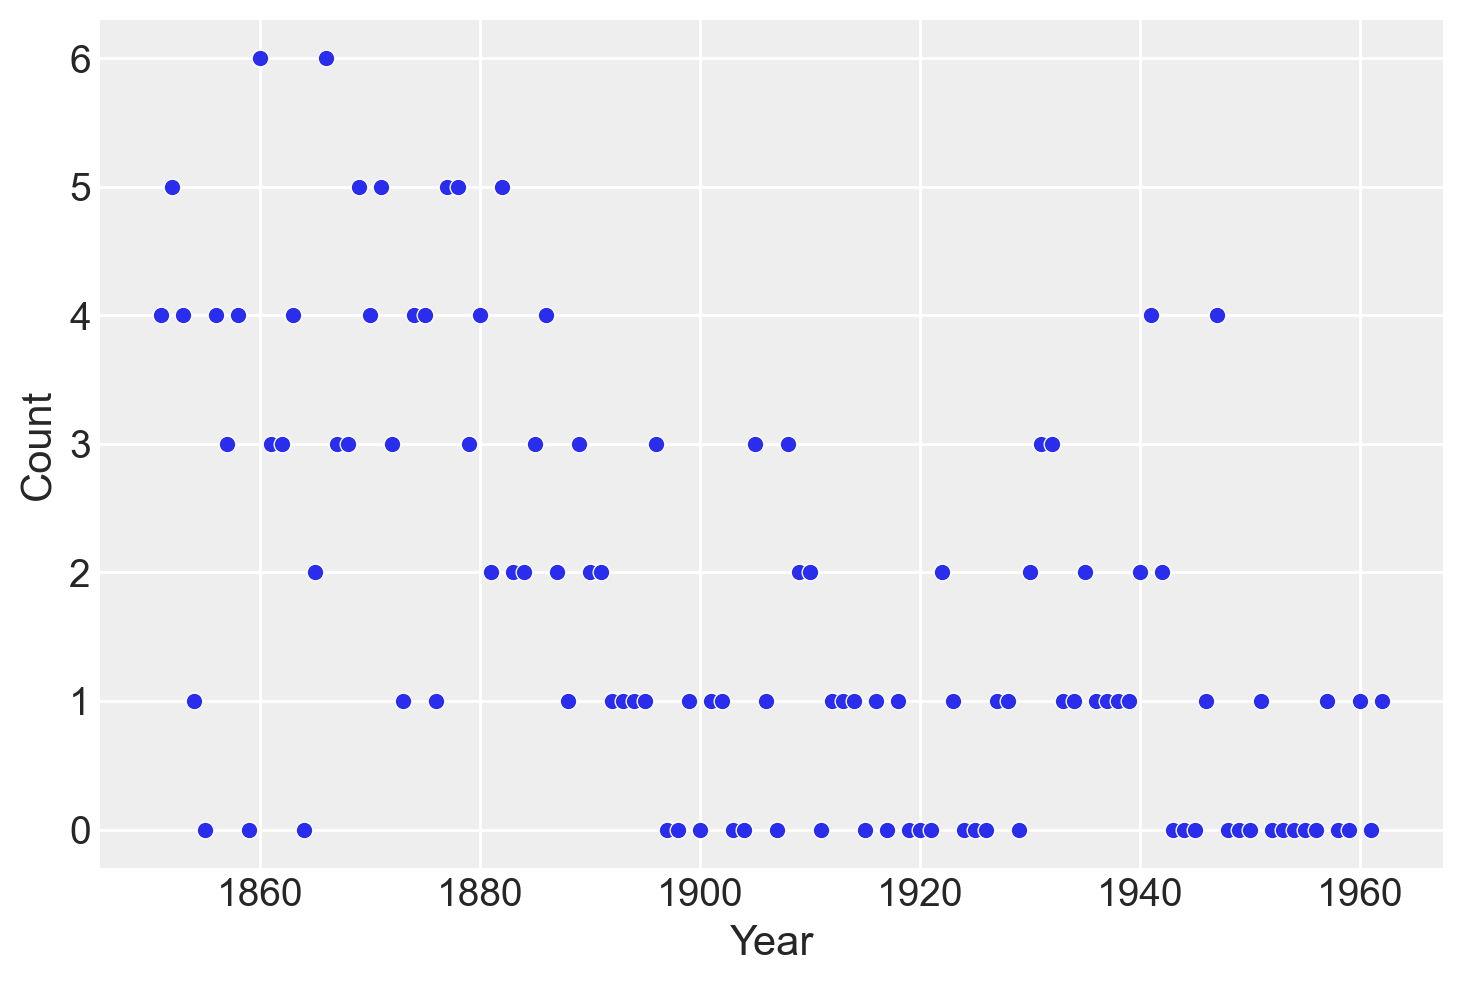

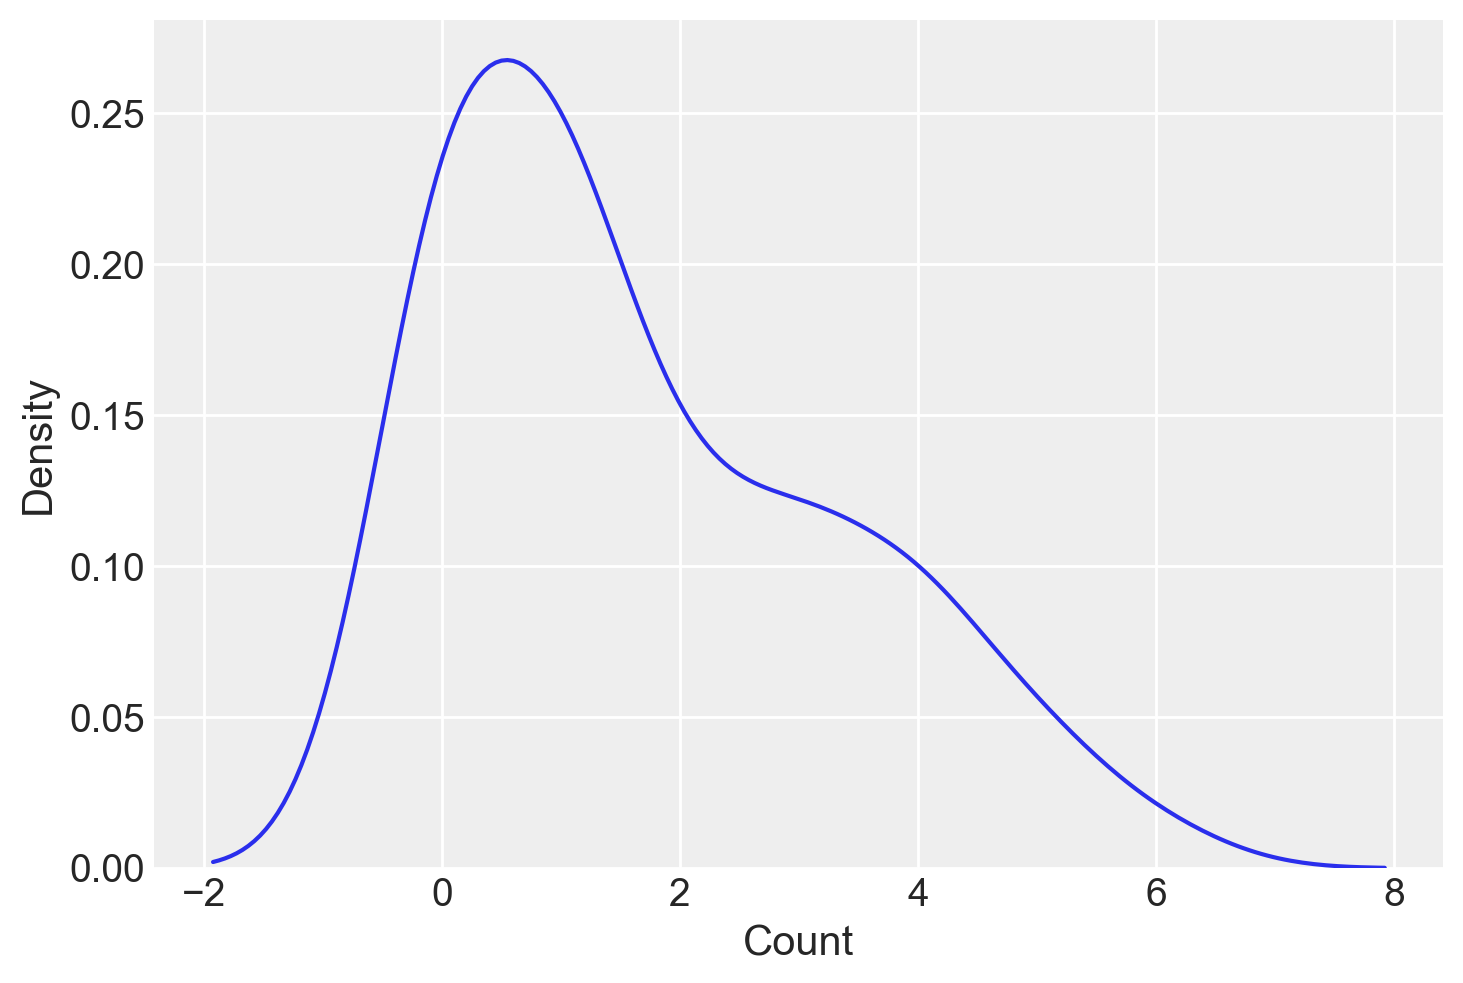

In [30]:
sns.scatterplot(x='Year', y='Count', data=disaster_data);
plt.show()
sns.kdeplot(x='Count', data=disaster_data);
plt.show()

By examining the plot above, it does appear that there is a change in the rate of mine disasters somewhere between 1880 and 1900. Further, one can see from both charts that many years has no disasters, where some years has as many as 6.   

To get a further feel for these data execute the code in the cell below to compute and display the mean intensity rate over the entire time period.   

In [31]:
print("Mean intensity rate = {0:4.2f}".format(np.mean(disaster_data.loc[:,'Count'])))

Mean intensity rate = 1.71


### Define the Bayesian model   

We are now ready to define our model in code as shown below. This code does the following:    
1. The prior for the switch point, $s$ uses the pymc [DiscreteUniform]9https://docs.pymc.io/en/v4.3.0/api/distributions/generated/pymc.DiscreteUniform.html) distribution function. Since the counts are aggregated annually, a discrete distribution is appropriate for this prior.     
2. The priors for the rates use the pymc [Exponential](https://docs.pymc.io/en/v4.3.0/api/distributions/generated/pymc.Exponential.html) distribution function with parameter 2.0.    
3. The switched rate is selected deterministically using the [pymc.math.switch](https://docs.pymc.io/en/latest/api/generated/pymc.math.switch.html) function, based on the switchpoint value.      
4. The posterior distribution of the disaster rate is computed using the pymc [Poisson](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.Poisson.html) distribution function using the value of the rate and the observed values, or evidence.    

Execute this code to compile the model.  

In [32]:
with pymc.Model() as disaster_model:
    # Uniform prior on the switch point  
    switchpoint = pymc.DiscreteUniform("switchpoint", lower=disaster_data.Year.min(), upper=disaster_data.Year.max())
#    switchpoint = pymc.Triangular("switchpoint", lower=disaster_data.Year.min(), upper=disaster_data.Year.max(), c=1900)

    # Priors for pre- and post-switch rates 
    early_rate = pymc.Exponential("early_rate", 2.0)
    late_rate = pymc.Exponential("late_rate", 2.0)

    # Poisson rate switch for years before and after current
    rate = pymc.math.switch(switchpoint >= disaster_data.Year, early_rate, late_rate)

    disasters = pymc.Poisson("disasters", rate, observed=disaster_data.Count)

### Prior predictive checks   

Before proceeding we must verify that we are happy with the prior distribution, from the prior predictive distributions. To start, execute the code in the cell below to sample the prior predictive distributions.       

In [33]:
SEED = 5678
with disaster_model:
    prior_checks = pymc.sample_prior_predictive(samples=50, random_seed=SEED)
prior_checks.keys()

Sampling: [disasters, early_rate, late_rate, switchpoint]


KeysView(Inference data with groups:
	> prior
	> prior_predictive
	> observed_data)

There are four distributions we should examine, the switch point, the density of disaster rate, the event rates before and after the switch point. Execute the code in the cell below to display the density plots of each.  

array([[<Axes: title={'center': 'early_rate'}>,
        <Axes: title={'center': 'late_rate'}>,
        <Axes: title={'center': 'switchpoint'}>]], dtype=object)

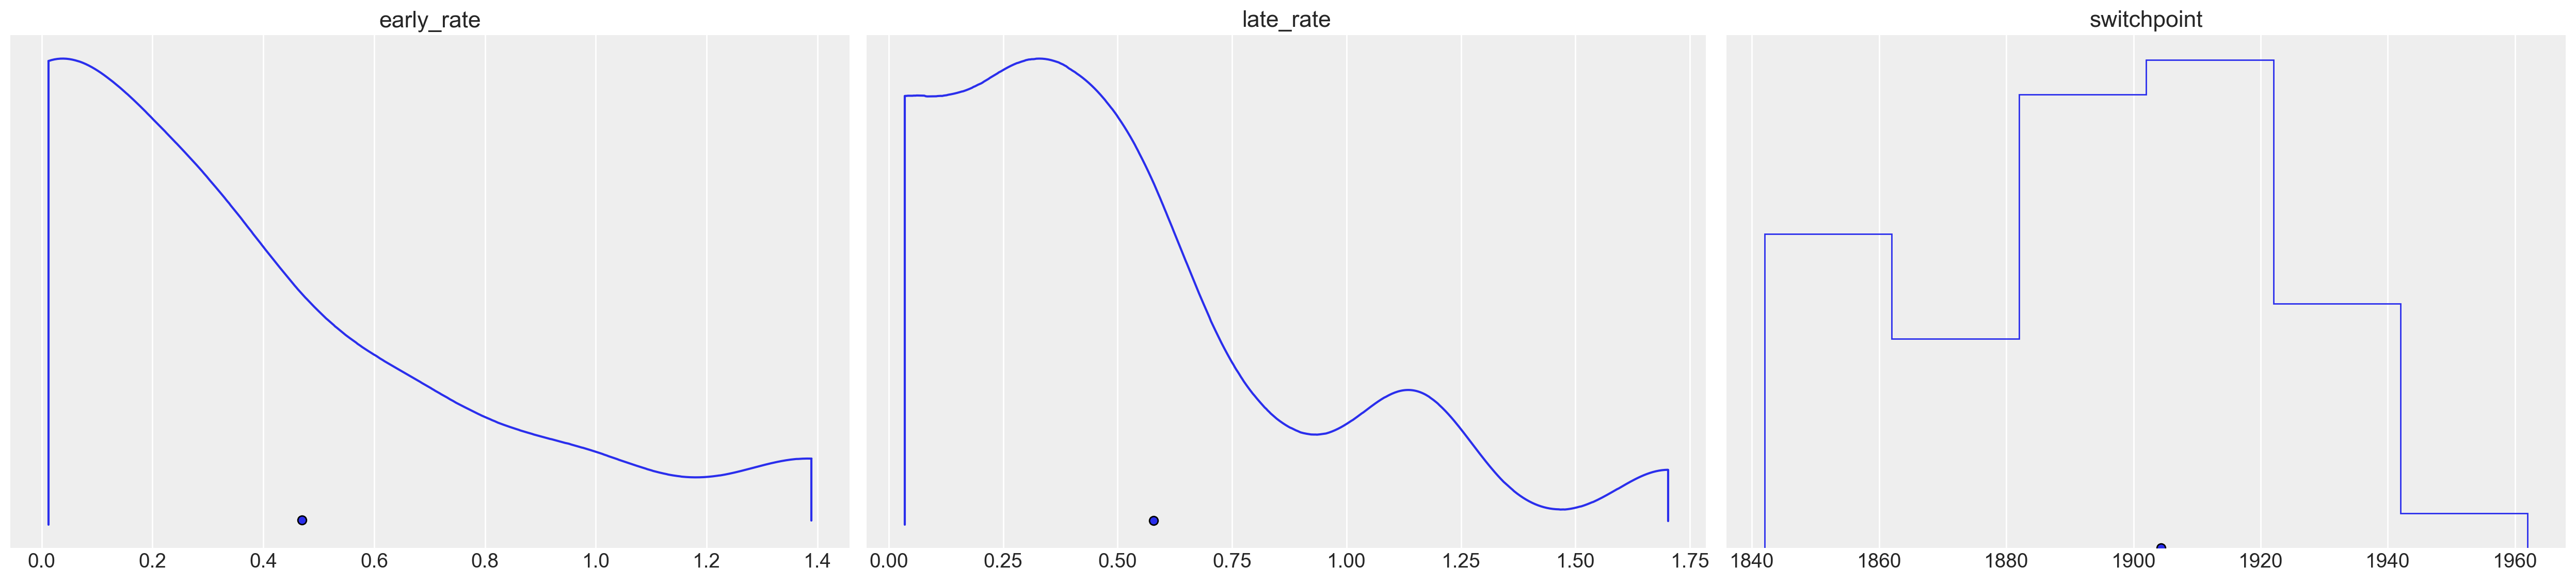

In [34]:
az.plot_density(prior_checks, group='prior')

Examine the plots noticing the following:     
1. The distribution of the switch point is a bimodal, likely a result of the two rates used.    
2. The rate density is just based on the counts of the number of incidents per year.     
3. The rate densities seem reasonable with long tails.     

Overall, these densities look reasonable, given what we know about the problem so far.   

### MCMC sampling the model    

Since we initially satisfied that the priors are reasonable, it is time to MCMC sample the model. Execute the code in the cell below to generate the sample traces.  

In [35]:
with disaster_model:
    # 5000 posterior sample draws
    disaster_samples = pymc.sample(draws=5000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [early_rate, late_rate]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


> **Exercise 29-8:** Notice that the M-H algorithm is used to sample the discrete uniform distribution. Why is it not possible to use the NUTS (or any Hamiltonian-based) sampling algorithm for this distribution?    

> **Answer:**    Because the switch point parameter follows a discrete uniform distribution. Hamiltonian-based methods like NUTS are designed for continuous variables, where gradients can be calculated. However, in the case of a discrete parameter like the switch point, gradients do not exist because the parameter does not change continuously; it jumps from one discrete value to another.  

Next, execute the code in the cell below to display the trace plots and the parameter distributions.   

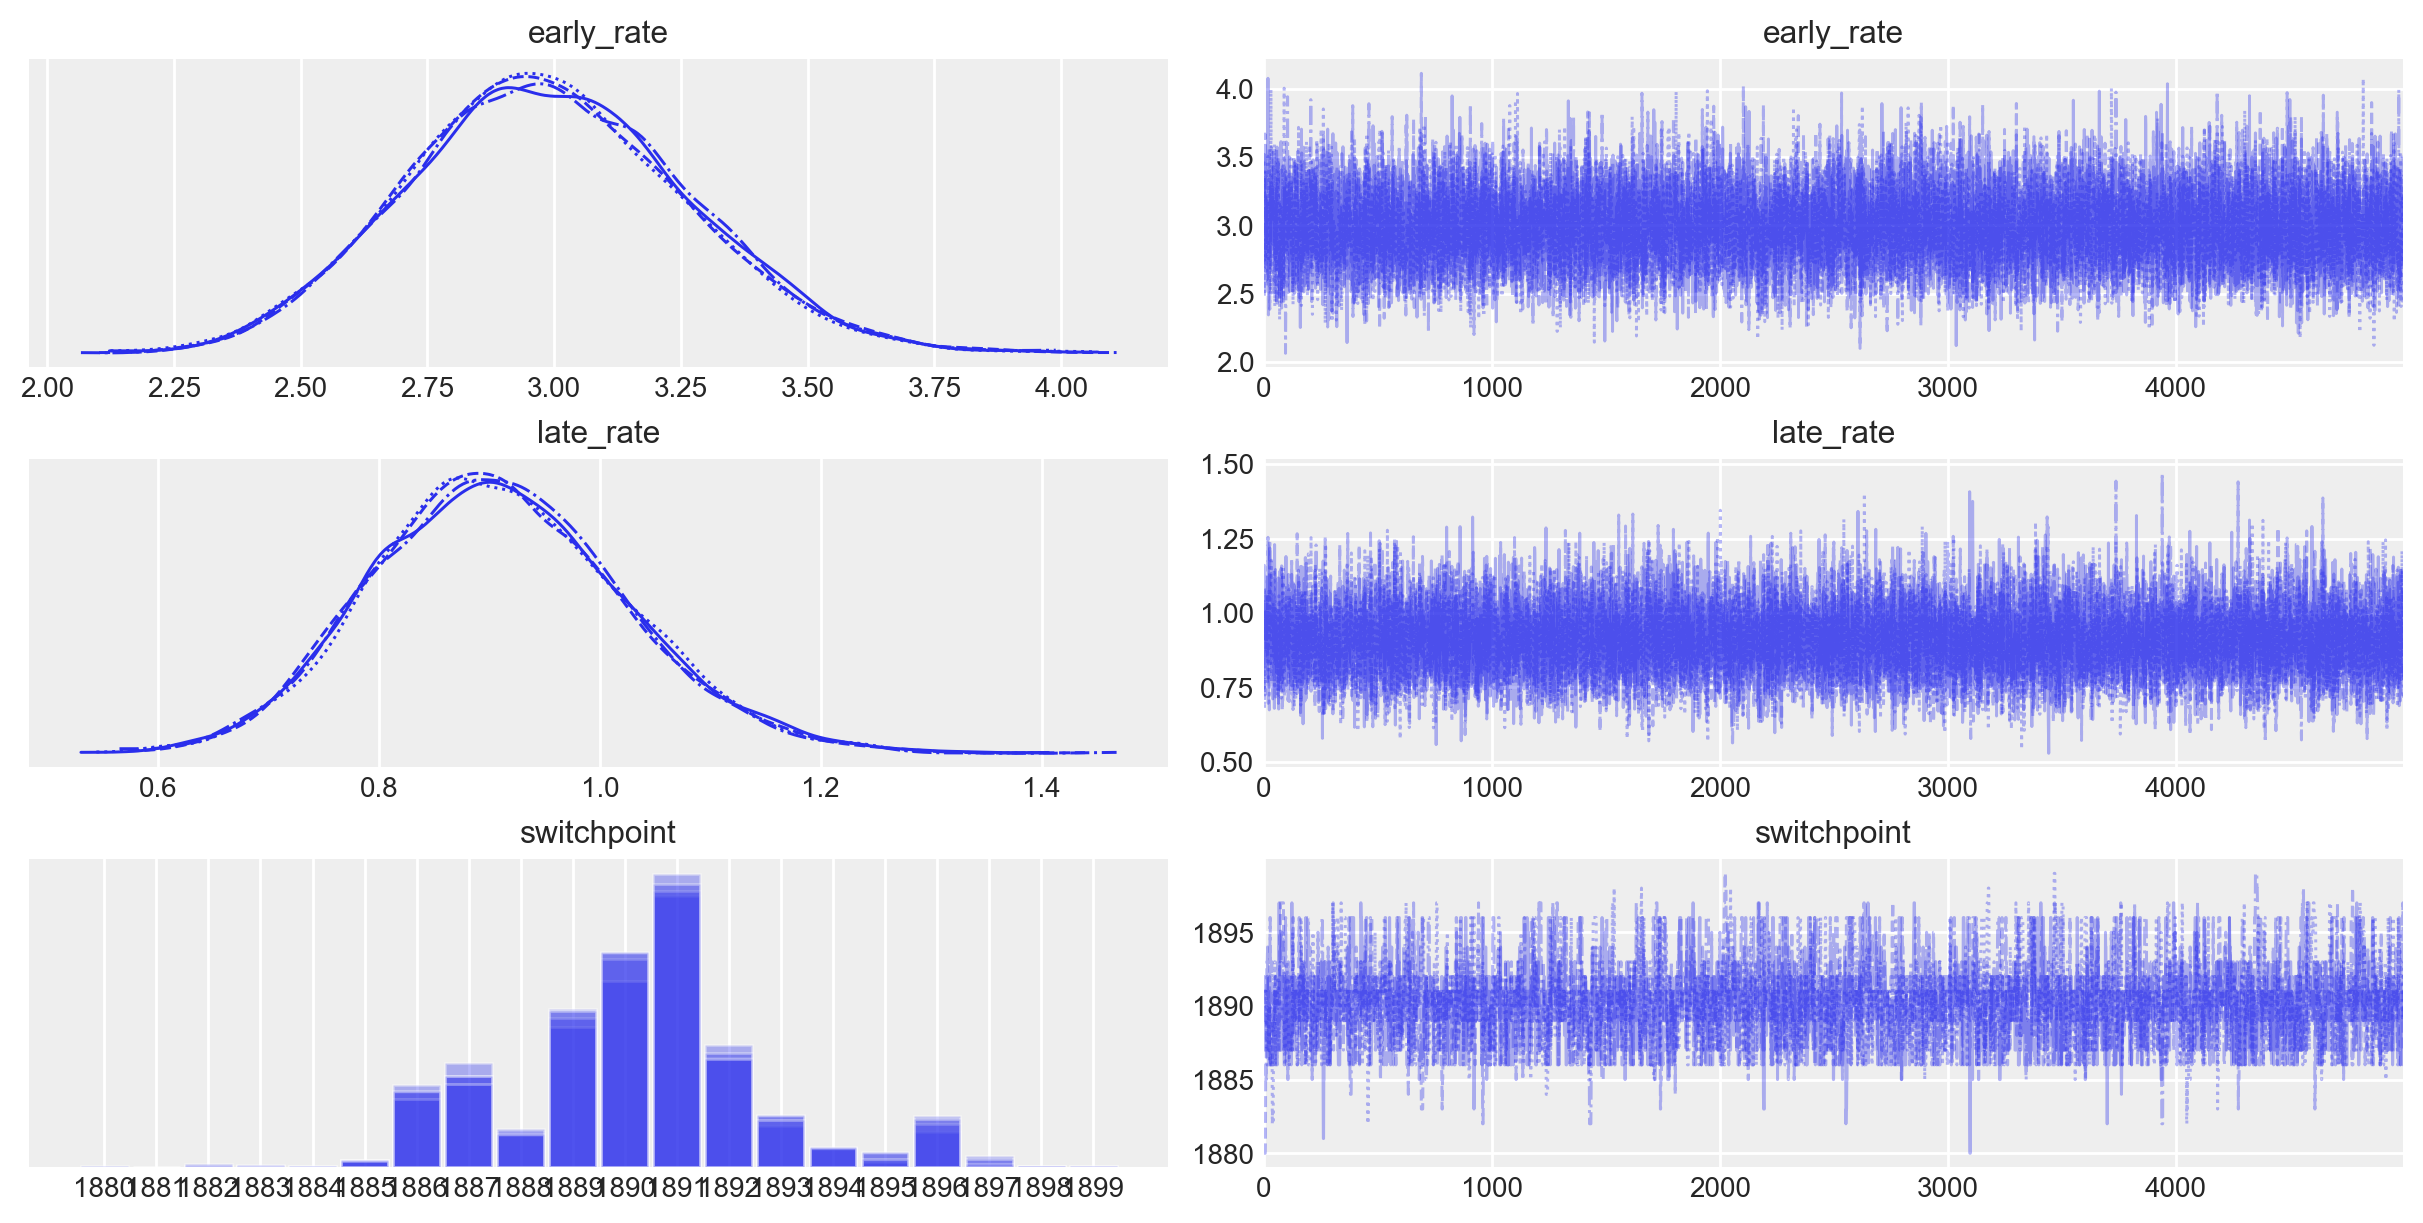

In [36]:
az.plot_trace(disaster_samples);

The trace plots look reasonable with constant variation over the sample. The distributions of the rate parameters also appear reasonable. However, the distribution of the switch point has several peaks (multi-modal). This may be a result of the multi-modal prior. None the less, the distribution looks reasonable.   

We must also verify that the sampling was effective. To do so we will compute and examine the MCSE and ESS for the sampling. Execute the code in the cell below to display these statistics.       

             mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
early_rate       0.002    0.002   13146.0   13571.0    1.0
late_rate        0.001    0.001   11717.0   13496.0    1.0
switchpoint      0.047    0.034    2711.0    3427.0    1.0


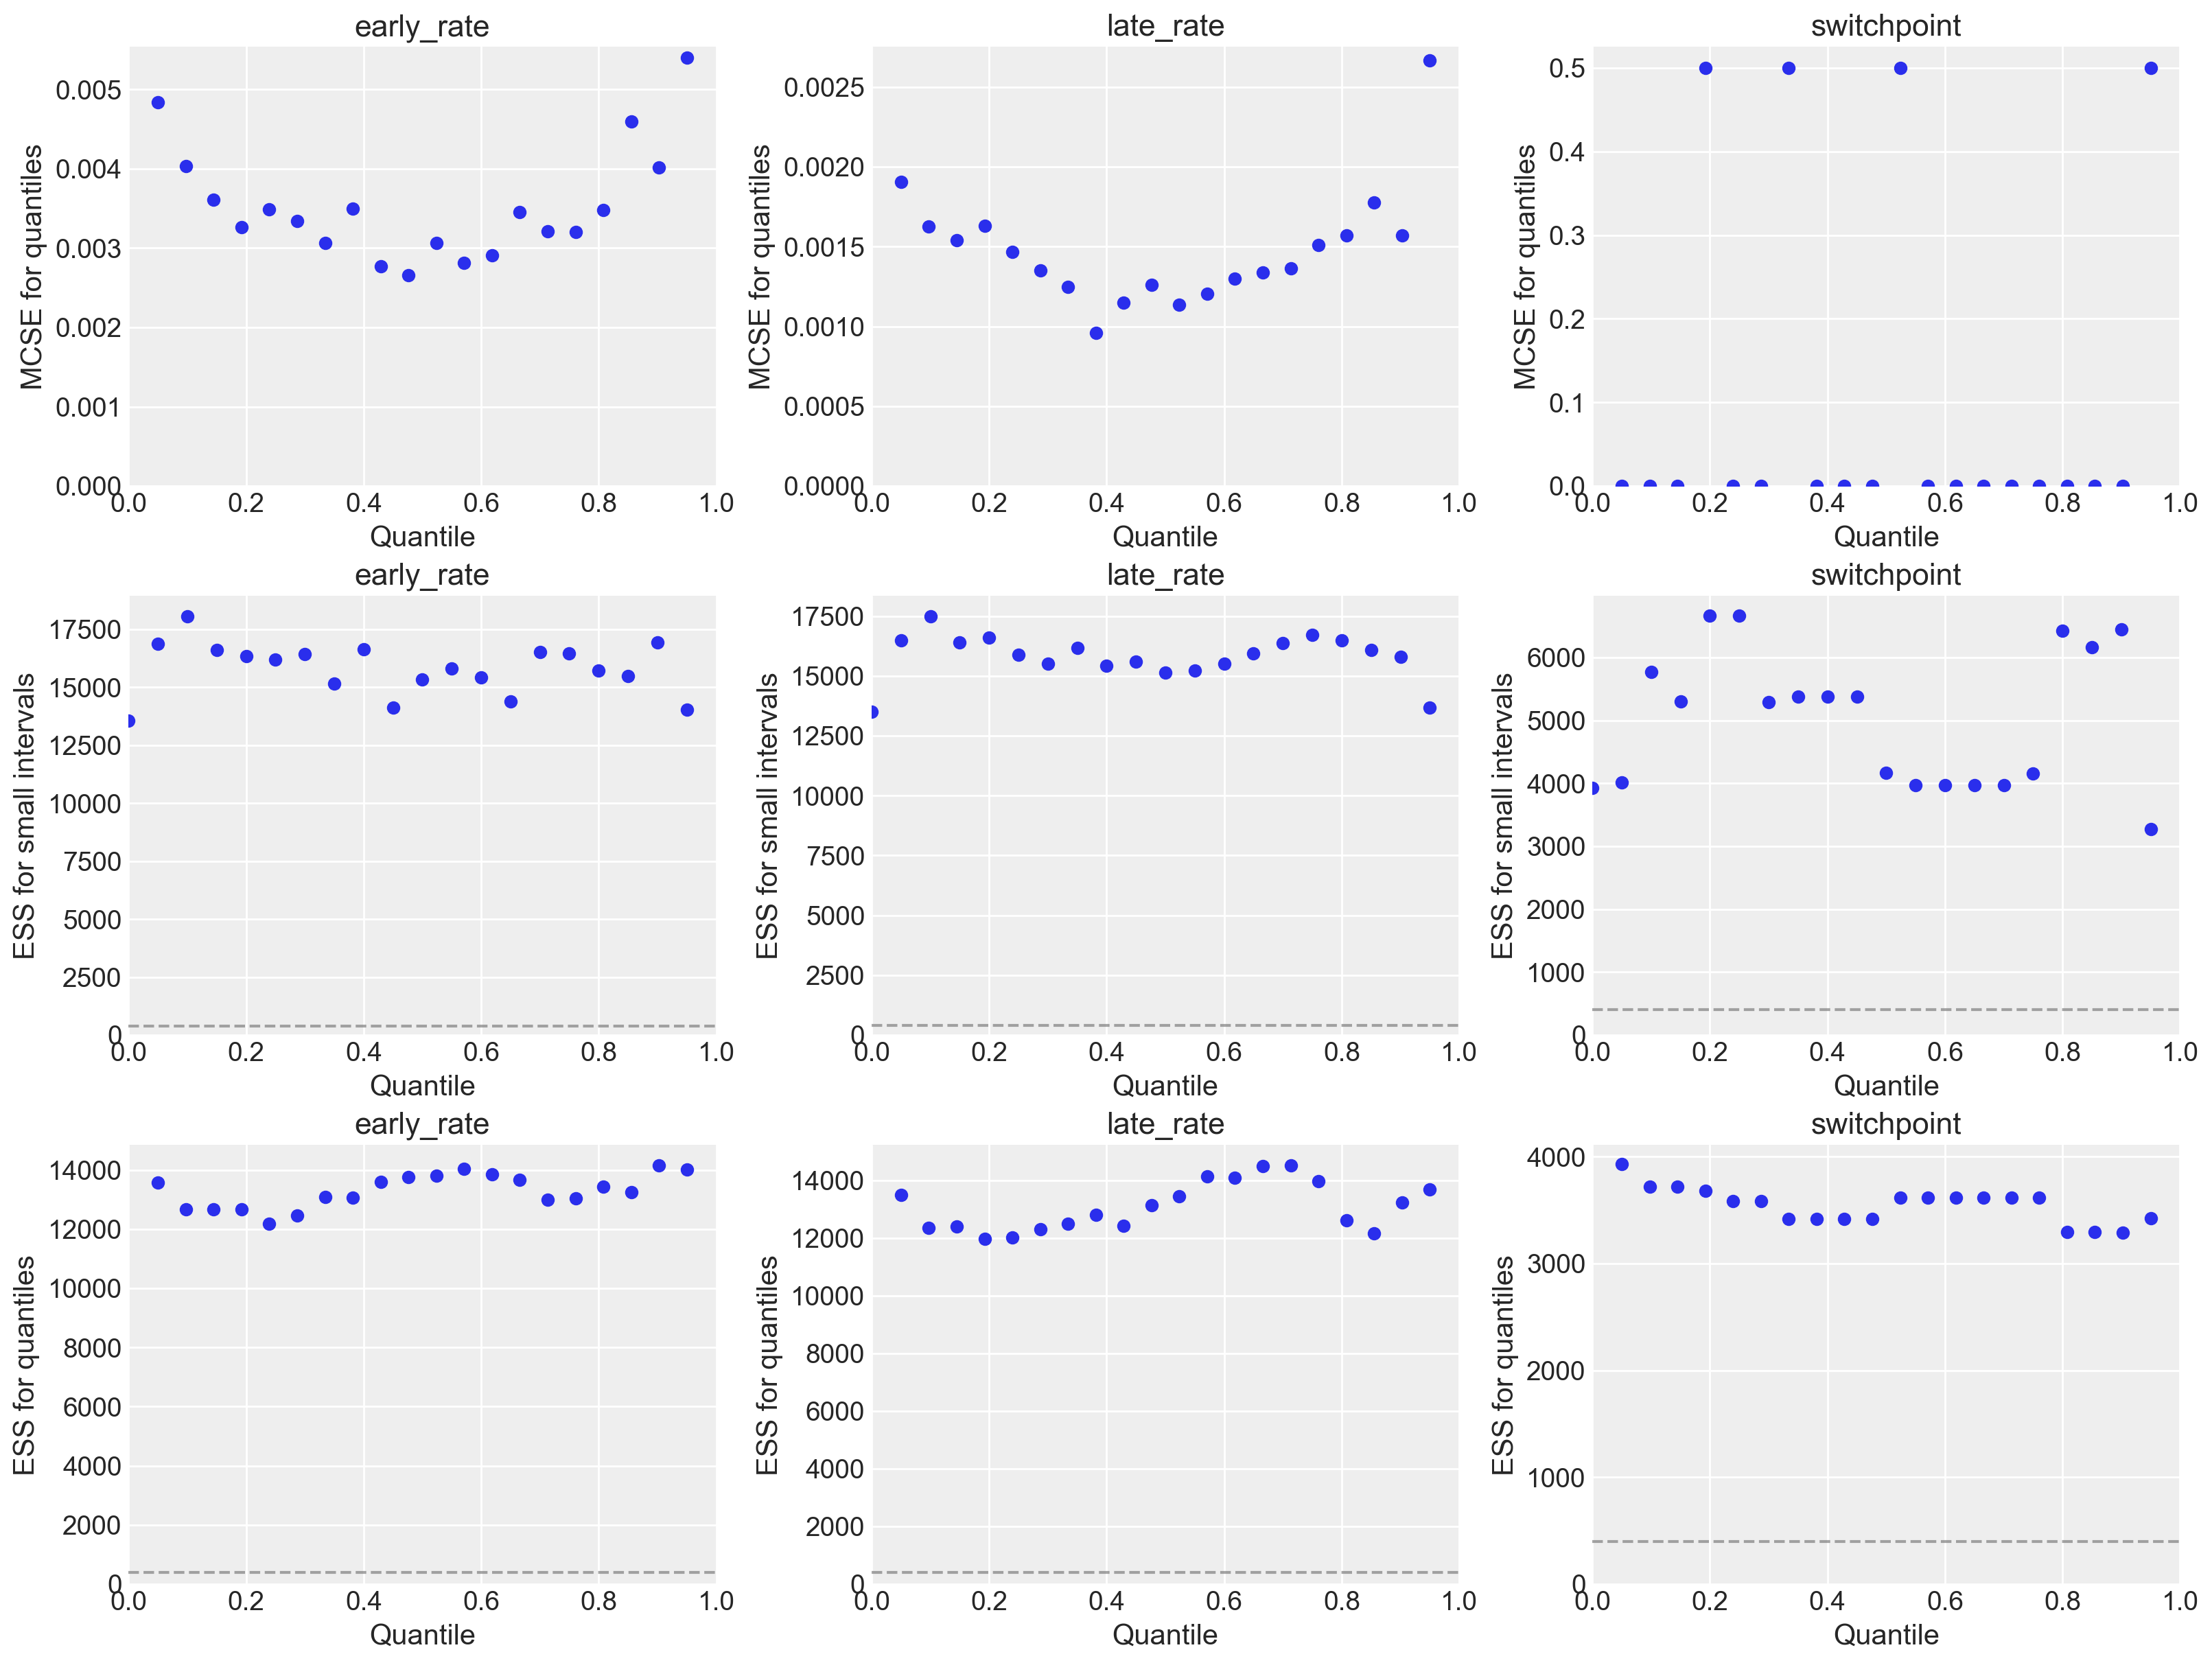

In [37]:
print(az.summary(disaster_samples, kind='diagnostics'))

_,ax = plt.subplots(3,3, figsize=(16,12))
az.plot_mcse(disaster_samples, ax=ax[0])
az.plot_ess(disaster_samples, kind="local", ax=ax[1]);
az.plot_ess(disaster_samples, kind="quantile", ax=ax[2]);

> **Exercise 29-9:** Examine the table and plots and answer the following questions:        
> 1. Is the MCSE for each of the coefficients reasonable and if not, why not?      
> 2. Are the local ESS values reasonable, and can you identify anything odd, and if so, what?     
> 3. Are the quantile ESS values reasonable, and can you identify anything odd, and if so, what?      

> **Answers:**     
> 1.  Yes, the Monte Carlo Standard Error values for each of the coefficients are reasonable. For the early_rate and late_rate, the MCSE values are very small, indicating that the posterior distributions are well-sampled and that the estimates for the rates are stable. For the switchpoint, the MCSE is slightly larger but still acceptable, given that the switchpoint distribution appears to be multimodal, which could introduce some additional variance.    
> 2.  The local Effective Sample Size (ESS) values for the early_rate and late_rate are quite high, which indicates that the sampling is efficient for these parameters. The ESS for the switchpoint, while lower, is still reasonable, though it is noticeably smaller compared to the other parameters.     
> 3.   The quantile ESS values are mostly consistent and reasonable for the early_rate and late_rate parameters across all quantiles. However, for the switchpoint, the ESS values are somewhat lower for certain quantiles, which reflects the complexity of sampling from a multimodal distribution. This is not unusual when the posterior distribution has multiple modes, as the sampler might spend more time in some regions of the distribution than others.  

## Posterior distributions   

With the traces computed, we can now examine the posterior distribution of the model parameters. Execute the code in the cell below to display the posterior distributions of the model parameters as forest plots and density plots.        

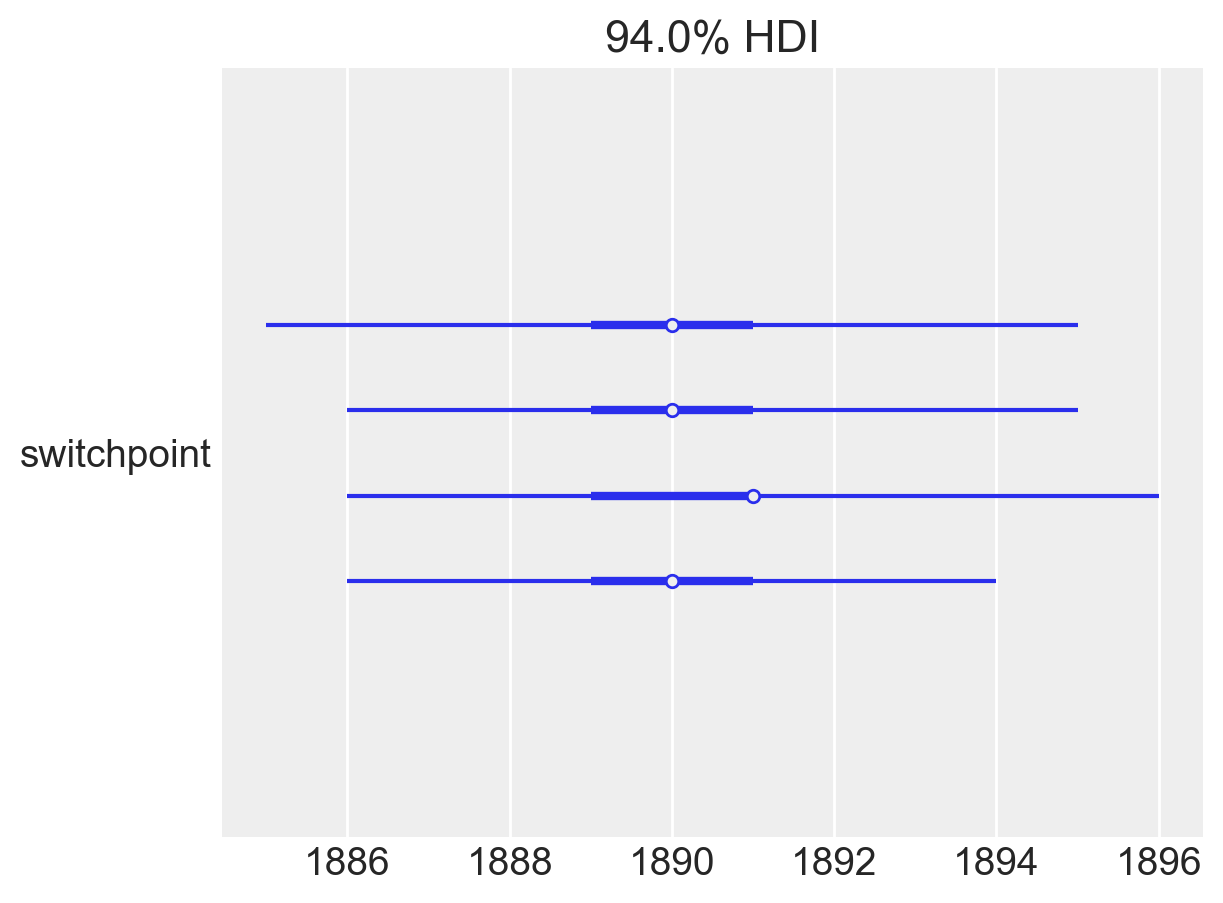

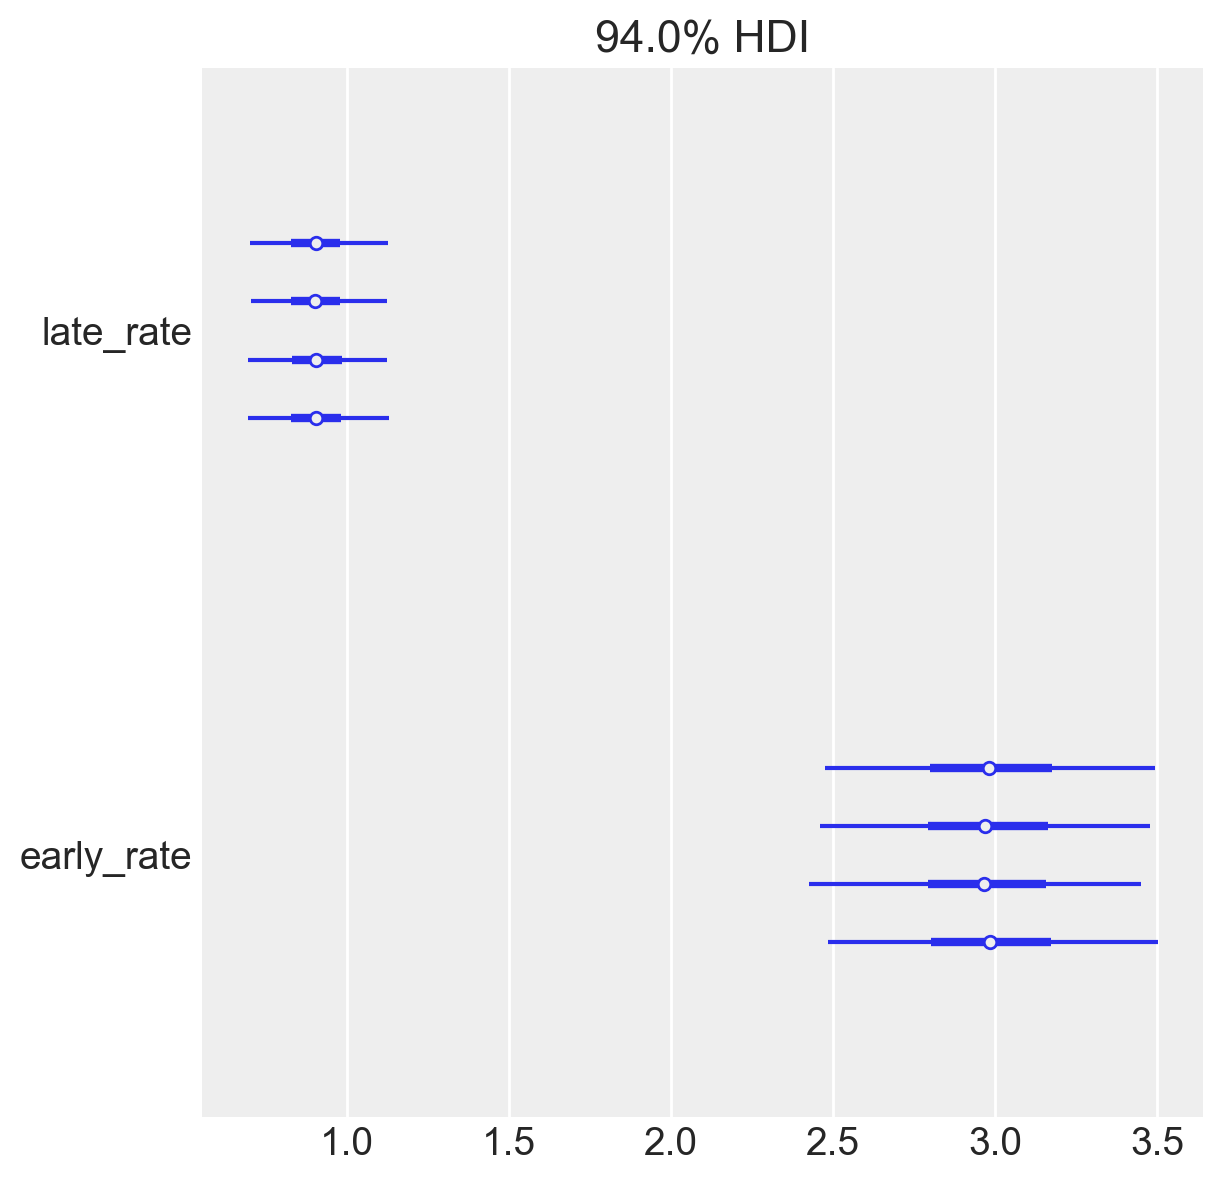

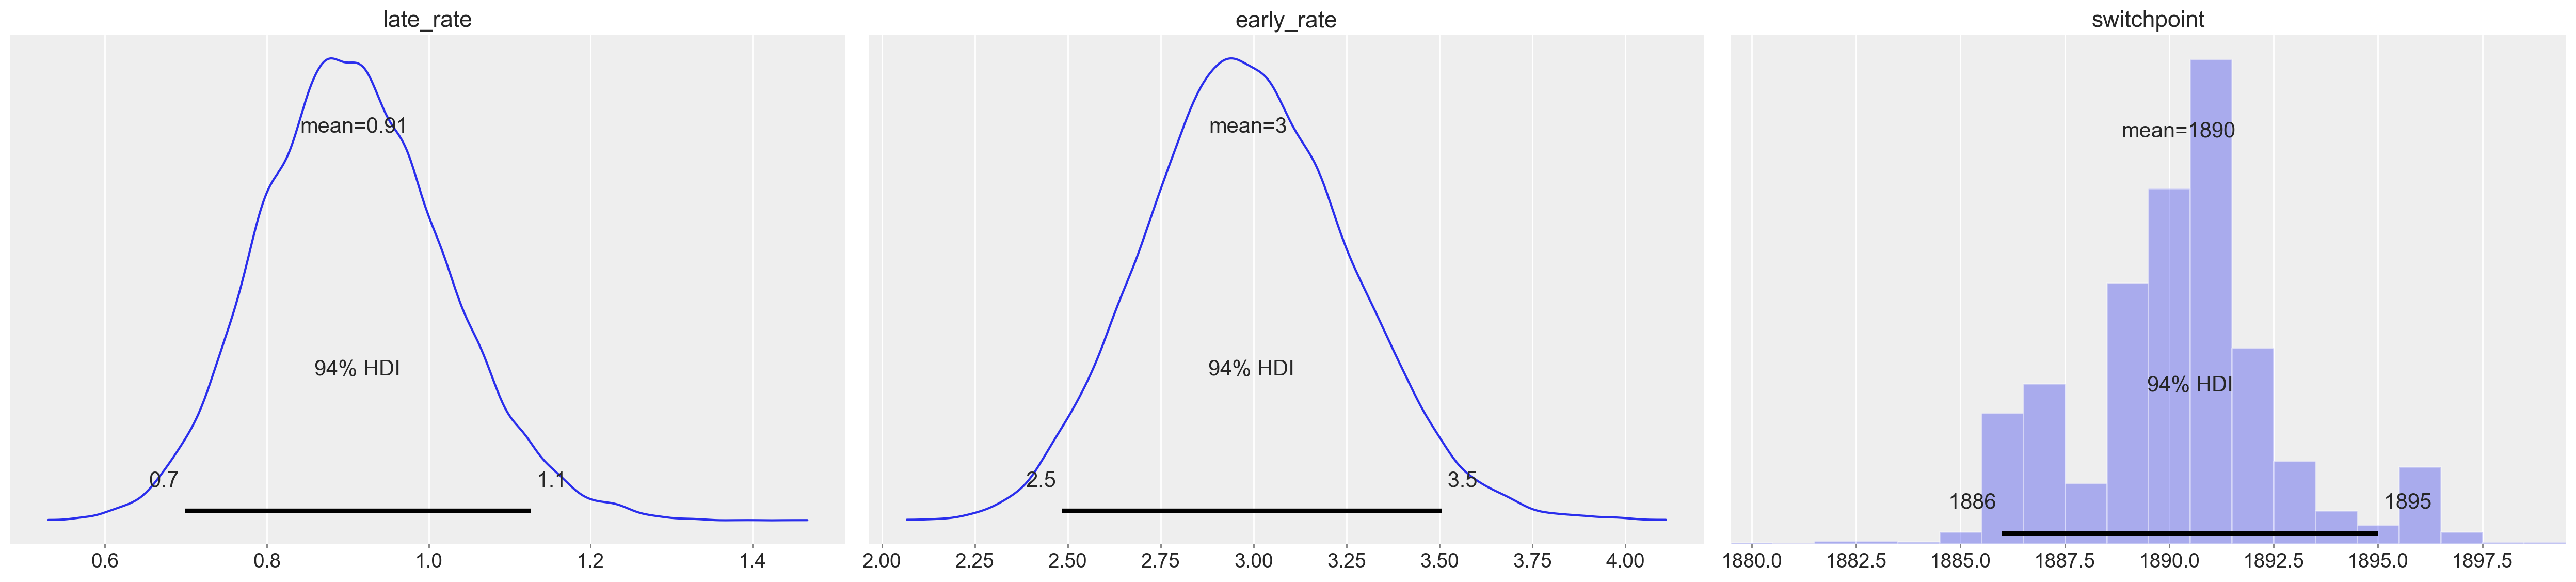

In [38]:
az.plot_forest(disaster_samples, var_names=['switchpoint']);
plt.show();
az.plot_forest(disaster_samples, var_names=['late_rate', 'early_rate']);
plt.show();
az.plot_posterior(disaster_samples, var_names=['late_rate', 'early_rate', 'switchpoint']); 
plt.show()

> **Exercise 29-10:** Examine the plots above, and answer these questions:       
> 1. Given the bit of history for this problem does the HDI of the switch-point seem reasonable and why?     
> 2. Is the difference in the rates of disasters before and after the switch point significantly different and why?    

> **Answers:**         
> 1.  Yes, seems reasonable. The HDI for the switch-point is centered around the late 1880s to early 1890s, which corresponds to the historical period when safety regulations in coal mining became more stringent according to the background introduction above. 
> 2.  Yes. The early rate (before the switch-point) is centered around 3 disasters per year, while the late rate (after the switch-point) is centered around 1 disaster per year. This is a substantial decrease in the rate of mining disasters, which makes sense given the historical implementation of improved safety measures. The HDI plots show clear separation between the early and late rates, indicating that the posterior estimates support a significant change in disaster rates around the switch-point.   

### Posterior checks     

There is one last aspect of this analysis we should investigate, the posterior predictive analysis. To start, execute the code in the cell below to create the posterior predictive samples.     

In [39]:
SEED = 4466
with disaster_model:
    pymc.sample_posterior_predictive(disaster_samples, extend_inferencedata=True, random_seed=SEED)

Sampling: [disasters]


Output()

To display the posterior predictive plots execute the code in the cell below.  

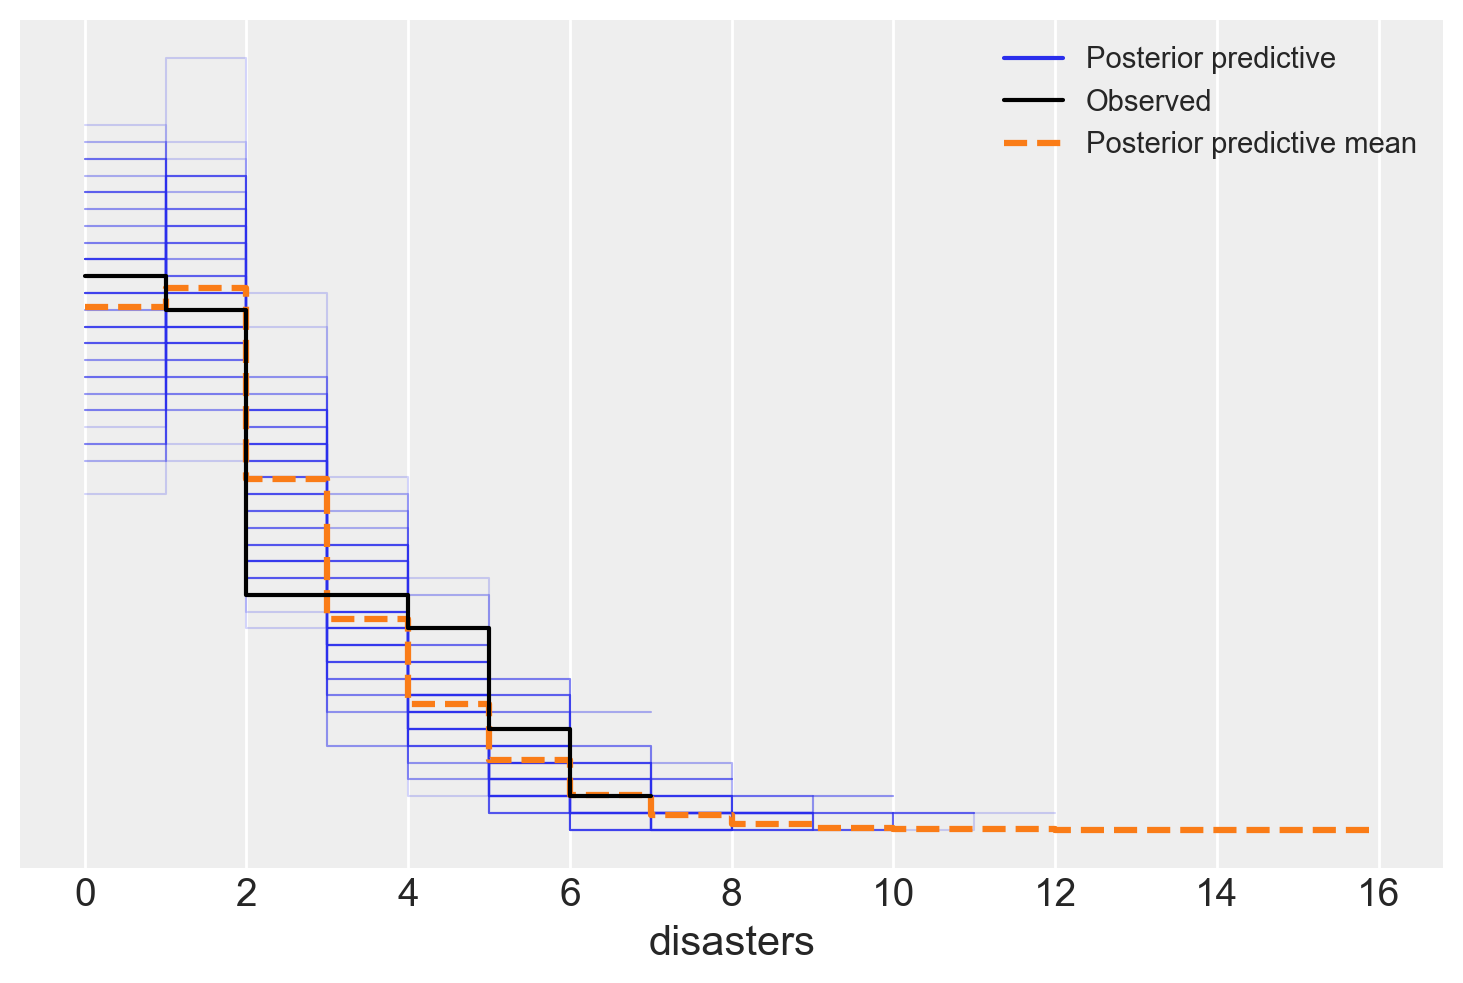

In [40]:
az.plot_ppc(disaster_samples, num_pp_samples=100);

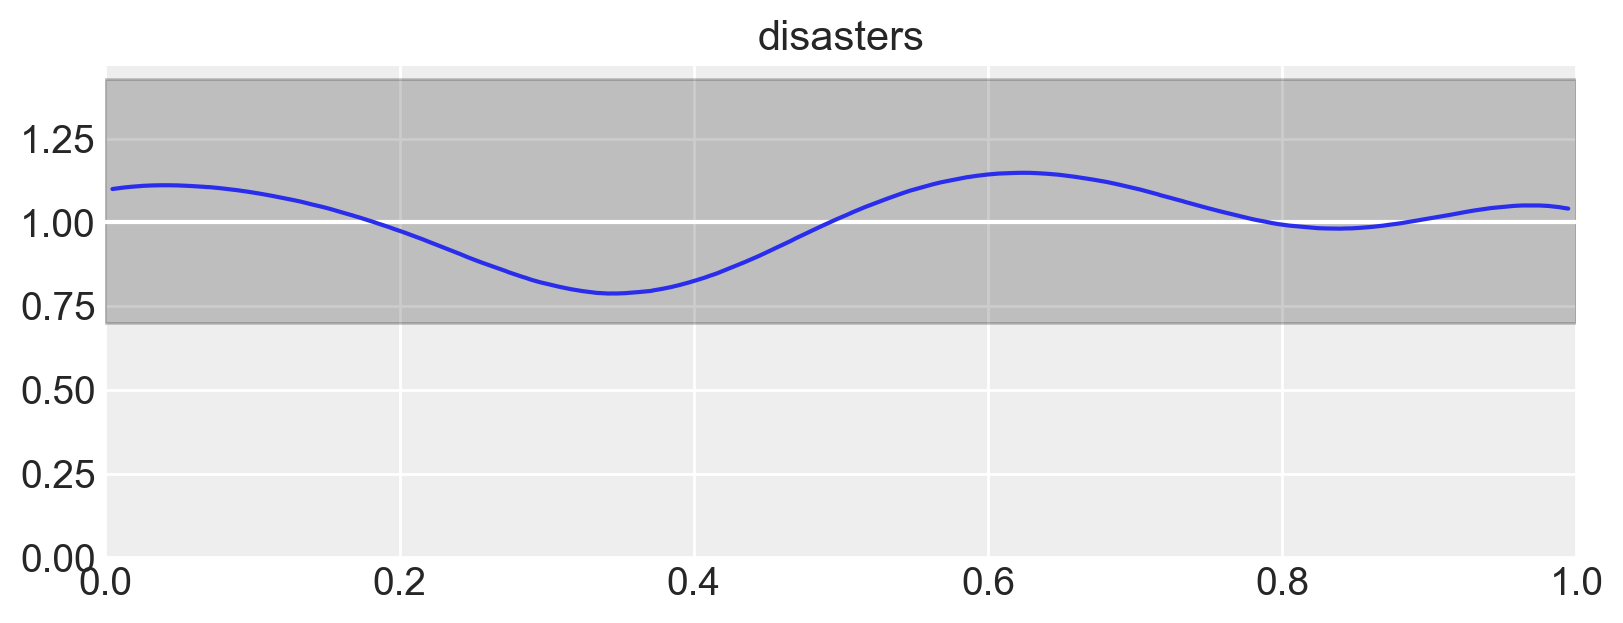

In [41]:
_,ax = plt.subplots(figsize=(8,3))
az.plot_bpv(disaster_samples, kind='u_value', ax=ax);

> **Exercise 29-11 :** Examine these plots and answer these questions:     
> 1. Do you see reasonable agreement between the prior predictive distribution and the observed values and why? For these data are there discrete blue lines at each disaster count?       
> 2. Does the plot of the Bayesian p-value show good agreement with the ideal distribution and what does this tell you about the predictions made by the model?    
> 3. Does the plot of the Bayesian u-values show good agreement with the ideal distribution and what does this tell you about the predictions made by the model?    

> **Answers:**        
> 1. Yes. The blue lines (posterior predictive) overlap well with the black lines (observed values), suggesting that the model is capturing the range of the disaster counts quite accurately. The discrete blue lines at each disaster count indicate that the model is predicting a plausible range of outcomes for the disaster counts, aligning with the observed data.     
> 2. The Bayesian p-value plot shows relatively good agreement, with values fluctuating around 0.5. This suggests that the model is well-calibrated and is producing predictions that are consistent with the observed data. The fact that the p-values do not show extreme deviations from 0.5 indicates that the model is neither systematically underpredicting nor overpredicting the disaster rates.    
> 3. Yes. The u-values fluctuate in a manner consistent with the expectation for a well-calibrated model. This tells us that the model is making predictions that cover the range of observed data well, and there is no significant bias in its predictions across different quantiles.    

## Summary

In this lesson you have done the following:

- Reviewed the basic properties of a Markov process and Markov chains.
- Perform a simple Markov chain Monte Carlo using the Metropolis-Hastings algorithm..
- Evaluated the convergence of the model. 
- Performing prior and posterior checks. 

#### Copyright 2017, 2018, 2019, 2020, 2022, 2023 Stephen F Elston. All rights reserved. 